In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import cv2
import os
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm


data = tfds.load('tf_flowers')
tf.config.list_physical_devices()


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## SRCNN and FSRCNN

In [27]:
train_data = data['train'].skip(600)
test_data = data['train'].take(600)

@tf.function
def build_data(data):
  cropped = tf.dtypes.cast(tf.image.random_crop(data['image'] / 255, (128, 128, 3)), tf.float32)
  lr = tf.image.resize(cropped, (64, 64))
  lr = tf.image.resize(lr, (128, 128), method = tf.image.ResizeMethod.BICUBIC)
  return (lr, cropped)

def downsample_image(image,scale):
  lr = tf.image.resize(image / 255, (image.shape[0]//scale, image.shape[1]//scale))
  lr = tf.image.resize(lr, (image.shape[0], image.shape[1]), method = tf.image.ResizeMethod.BICUBIC)
  return lr

def upsample_image(image,scale):
  hr = tf.image.resize(image / 255, (image.shape[0] * scale, image.shape[1] * scale), method=tf.image.ResizeMethod.BICUBIC)
  hr = tf.image.resize(hr, (256, 256), method=tf.image.ResizeMethod.BICUBIC)
  return hr

In [28]:
train_dataset_mapped = train_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE)
def show_image():
    for x in train_dataset_mapped.take(1):
      plt.imshow(x[0].numpy())
      plt.show()
      plt.imshow(x[1].numpy())
      plt.show()

In [29]:
SRCNN_915=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,9,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(64,1,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(3,5,padding='same',activation='relu')
])
def pixel_mse_loss(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

def PSNR(y_true,y_pred):
  mse = tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.log(x)
  denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

SRCNN_915.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = pixel_mse_loss)

In [30]:
total_iterations = 20
for iteration in range(total_iterations):
    print(f"Iteration: {iteration + 1} / {total_iterations}")
    train_dataset_mapped = train_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(128)
    val_dataset_mapped = test_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(128)
    SRCNN_915.fit(train_dataset_mapped, epochs = 1,validation_data = val_dataset_mapped)

Iteration: 1 / 20
24/24 [==============================] - 18s 476ms/step - loss: 0.0342 - val_loss: 0.0143
Iteration: 2 / 20
24/24 [==============================] - 5s 192ms/step - loss: 0.0118 - val_loss: 0.0094
Iteration: 3 / 20
24/24 [==============================] - 5s 191ms/step - loss: 0.0080 - val_loss: 0.0072
Iteration: 4 / 20
24/24 [==============================] - 5s 188ms/step - loss: 0.0066 - val_loss: 0.0059
Iteration: 5 / 20
24/24 [==============================] - 4s 181ms/step - loss: 0.0057 - val_loss: 0.0053
Iteration: 6 / 20
24/24 [==============================] - 4s 184ms/step - loss: 0.0052 - val_loss: 0.0050
Iteration: 7 / 20
24/24 [==============================] - 5s 202ms/step - loss: 0.0050 - val_loss: 0.0062
Iteration: 8 / 20
24/24 [==============================] - 4s 184ms/step - loss: 0.0049 - val_loss: 0.0045
Iteration: 9 / 20
24/24 [==============================] - 5s 187ms/step - loss: 0.0043 - val_loss: 0.0044
Iteration: 10 / 20
24/24 [==========

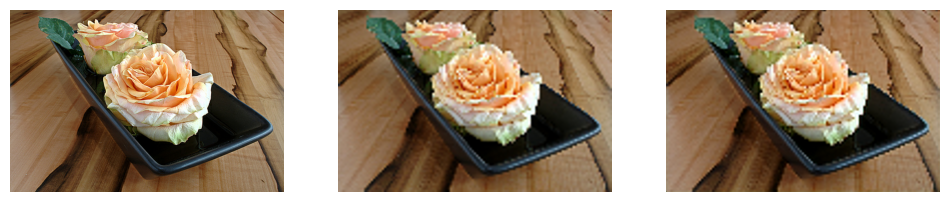

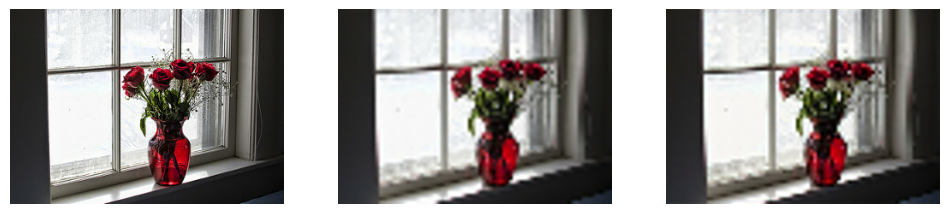

In [31]:
train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE)
for x in train_data.take(2):
  fig = plt.figure(figsize=(12,4))

  plt.subplot(1,3,1)
  plt.imshow(x['image'].numpy())
  plt.axis('off')
  plt.subplot(1,3,2)
  lr = downsample_image(x['image'].numpy(),4)
  plt.imshow(lr.numpy())
  plt.axis('off')
  plt.subplot(1,3,3)
  pred = SRCNN_915(np.array([lr]))
  plt.imshow(pred[0].numpy())
  plt.axis('off')
  plt.show()

In [35]:
FSRCNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 9, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(64, 1, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(3, 5, padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2DTranspose(3, 3, padding = 'same', activation = 'relu')
])

FSRCNN.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=pixel_mse_loss)

In [36]:
total_iterations = 20
train_data = data['train'].skip(600)
test_data = data['train'].take(600)
train_dataset_mapped = train_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE)
for iteration in range(total_iterations):
    print(f"Iteration: {iteration + 1} / {total_iterations}")
    train_dataset_mapped = train_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(128)
    val_dataset_mapped = test_data.map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(128)
    FSRCNN.fit(train_dataset_mapped, epochs = 1,validation_data = val_dataset_mapped)

Iteration: 1 / 20
24/24 [==============================] - 9s 253ms/step - loss: 0.1226 - val_loss: 0.0980
Iteration: 2 / 20
24/24 [==============================] - 5s 196ms/step - loss: 0.0405 - val_loss: 0.0186
Iteration: 3 / 20
24/24 [==============================] - 4s 186ms/step - loss: 0.0157 - val_loss: 0.0126
Iteration: 4 / 20
24/24 [==============================] - 5s 207ms/step - loss: 0.0111 - val_loss: 0.0099
Iteration: 5 / 20
24/24 [==============================] - 5s 199ms/step - loss: 0.0091 - val_loss: 0.0082
Iteration: 6 / 20
24/24 [==============================] - 6s 237ms/step - loss: 0.0077 - val_loss: 0.0072
Iteration: 7 / 20
24/24 [==============================] - 5s 192ms/step - loss: 0.0068 - val_loss: 0.0064
Iteration: 8 / 20
24/24 [==============================] - 5s 200ms/step - loss: 0.0063 - val_loss: 0.0060
Iteration: 9 / 20
24/24 [==============================] - 5s 196ms/step - loss: 0.0058 - val_loss: 0.0058
Iteration: 10 / 20
24/24 [===========

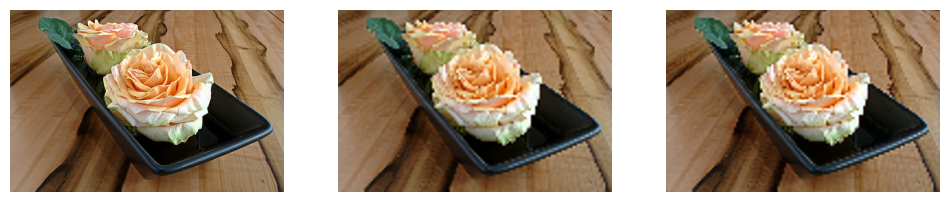

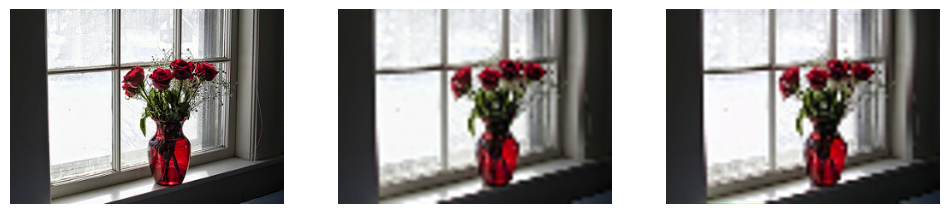

In [37]:
train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE)
for x in train_data.take(2):
  fig = plt.figure(figsize=(12,4))
  plt.subplot(1,3,1)
  plt.imshow(x['image'].numpy())
  plt.axis('off')
  plt.subplot(1,3,2)
  lr = downsample_image(x['image'].numpy(),4)
  plt.imshow(lr.numpy())
  plt.axis('off')
  plt.subplot(1,3,3)
  pred = FSRCNN(np.array([lr]))
  plt.imshow(pred[0].numpy())
  plt.axis('off')
  plt.show()

## SRGAN

# extracting images from dataset 'tf_flowers'; total 600 images extracted


In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
from PIL import Image
import random

data, info = tfds.load("tf_flowers", with_info=True)

target_dir = "/content/gdrive/MyDrive/Deep_learning/fl_dt"

os.makedirs(target_dir, exist_ok=True)

dataset_list = list(data["train"].as_numpy_iterator())
random.shuffle(dataset_list)


images_extracted = 0

num_images_to_save = 600


for example in dataset_list:
    image = example["image"]
    label = example["label"]
    class_name = info.features["label"].int2str(label)


    image_filename = f"{class_name}_{label}_{hash(image.tobytes()):016x}.jpg"
    target_path = os.path.join(target_dir, image_filename)


    image_pil = Image.fromarray(image)
    image_pil.save(target_path)


    images_extracted += 1


    if images_extracted >= num_images_to_save:
        break

print(f"Saved {num_images_to_save} random images from the TF Flowers dataset to {target_dir}")


Saved 600 random images from the TF Flowers dataset to /content/gdrive/MyDrive/Deep_learning/fl_dt


In [11]:
train_dir = "/content/gdrive/MyDrive/Deep_learning/fl_dt"

output_hr_dir = os.path.join(train_dir, "hr_images_1")
output_lr_dir = os.path.join(train_dir, "lr_images_1")
os.makedirs(output_hr_dir, exist_ok=True)
os.makedirs(output_lr_dir, exist_ok=True)

for img_filename in os.listdir(train_dir):
    img_path = os.path.join(train_dir, img_filename)
    img_array = cv2.imread(img_path)

    if img_array is not None and img_array.shape[0] > 0 and img_array.shape[1] > 0:
        print(f"Processing: {img_filename} - Original Shape: {img_array.shape}")
        img_array_hr = cv2.resize(img_array, (128, 128))
        img_array_lr = cv2.resize(img_array, (32, 32))
        cv2.imwrite(os.path.join(output_hr_dir, img_filename), img_array_hr)
        cv2.imwrite(os.path.join(output_lr_dir, img_filename), img_array_lr)
        print(f"Processed: {img_filename} - HR Shape: {img_array_hr.shape}, LR Shape: {img_array_lr.shape}")
    else:
        print(f"Error processing image: {img_filename}")


Processing: dandelion_0_5e05fc3deba70686.jpg - Original Shape: (331, 500, 3)
Processed: dandelion_0_5e05fc3deba70686.jpg - HR Shape: (128, 128, 3), LR Shape: (32, 32, 3)
Processing: dandelion_0_-5b77a2710ea448d6.jpg - Original Shape: (240, 240, 3)
Processed: dandelion_0_-5b77a2710ea448d6.jpg - HR Shape: (128, 128, 3), LR Shape: (32, 32, 3)
Processing: tulips_2_0aee7b5be732fe5b.jpg - Original Shape: (333, 500, 3)
Processed: tulips_2_0aee7b5be732fe5b.jpg - HR Shape: (128, 128, 3), LR Shape: (32, 32, 3)
Processing: daisy_1_-79429a10f29c55dd.jpg - Original Shape: (240, 320, 3)
Processed: daisy_1_-79429a10f29c55dd.jpg - HR Shape: (128, 128, 3), LR Shape: (32, 32, 3)
Processing: roses_4_3b4f929c13bb7339.jpg - Original Shape: (248, 320, 3)
Processed: roses_4_3b4f929c13bb7339.jpg - HR Shape: (128, 128, 3), LR Shape: (32, 32, 3)
Processing: dandelion_0_-203c9b1c399d4cb6.jpg - Original Shape: (240, 320, 3)
Processed: dandelion_0_-203c9b1c399d4cb6.jpg - HR Shape: (128, 128, 3), LR Shape: (32, 32,

In [12]:

def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model


def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)


def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model



def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


In [13]:
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [14]:
lr_list = os.listdir("/content/gdrive/MyDrive/Deep_learning/fl_dt/lr_images_1")

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/gdrive/MyDrive/Deep_learning/fl_dt/lr_images_1/" + img)
    if img_lr is not None:
        img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
        lr_images.append(img_lr)

hr_list = os.listdir("/content/gdrive/MyDrive/Deep_learning/fl_dt/hr_images_1")

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/gdrive/MyDrive/Deep_learning/fl_dt/hr_images_1/" + img)
    if img_hr is not None:
        img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
        hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)



In [15]:
lr_images = lr_images / 255.
hr_images = hr_images / 255.

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                                                      test_size=0.33, random_state=42)


hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 32, 32, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 32, 32, 64)           64        ['conv2d_3[0][0]']            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 32, 32, 64)           36928     ['p_re_lu[0][0]']             
                                                                                              

In [17]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])


epochs = 10
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1))

    g_losses = []
    d_losses = []


    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]

        fake_imgs = generator.predict_on_batch(lr_imgs)


        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)


        discriminator.trainable = False


        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)


        image_features = vgg.predict(hr_imgs)



        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])


        d_losses.append(d_loss)
        g_losses.append(g_loss)

    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    generator.save("/content/gdrive/MyDrive/Deep_learning/gen_e.h5")

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 128, 128, 3)          2044291   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    3824928   ['model[0][0]']               
                                                          1                                 

  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 0s 480ms/step


  0%|          | 1/402 [01:14<8:16:02, 74.22s/it]

1/1 [==============================] - 0s 16ms/step


  0%|          | 2/402 [01:14<3:24:30, 30.68s/it]

1/1 [==============================] - 0s 17ms/step


  1%|          | 3/402 [01:14<1:51:29, 16.76s/it]

1/1 [==============================] - 0s 16ms/step


  1%|          | 4/402 [01:14<1:07:46, 10.22s/it]

1/1 [==============================] - 0s 17ms/step


  1%|          | 5/402 [01:14<43:39,  6.60s/it]  

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 6/402 [01:15<29:08,  4.42s/it]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 7/402 [01:15<19:59,  3.04s/it]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 8/402 [01:15<14:00,  2.13s/it]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 9/402 [01:15<09:59,  1.53s/it]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 10/402 [01:15<07:15,  1.11s/it]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 11/402 [01:16<05:23,  1.21it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 12/402 [01:16<04:04,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 13/402 [01:16<03:09,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 14/402 [01:16<02:31,  2.56it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 15/402 [01:16<02:04,  3.10it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 16/402 [01:16<01:46,  3.61it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 17/402 [01:17<01:34,  4.09it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 18/402 [01:17<01:29,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 19/402 [01:17<01:23,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 20/402 [01:17<01:17,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 21/402 [01:17<01:12,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 22/402 [01:18<01:10,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 23/402 [01:18<01:07,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 24/402 [01:18<01:04,  5.83it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 25/402 [01:18<01:02,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 26/402 [01:18<01:00,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 27/402 [01:18<01:02,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 28/402 [01:18<01:03,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 29/402 [01:19<01:03,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 30/402 [01:19<01:05,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 31/402 [01:19<01:07,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 32/402 [01:19<01:08,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 33/402 [01:19<01:05,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 34/402 [01:20<01:03,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 35/402 [01:20<01:01,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 36/402 [01:20<00:59,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 37/402 [01:20<01:01,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 38/402 [01:20<01:00,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 39/402 [01:20<00:58,  6.18it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 40/402 [01:21<01:00,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 41/402 [01:21<01:02,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 42/402 [01:21<01:02,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 43/402 [01:21<01:02,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 44/402 [01:21<01:03,  5.67it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 45/402 [01:22<01:10,  5.05it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█▏        | 46/402 [01:22<01:16,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 47/402 [01:22<01:18,  4.55it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 48/402 [01:22<01:16,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 49/402 [01:22<01:17,  4.57it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 50/402 [01:23<01:21,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 51/402 [01:23<01:24,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 52/402 [01:23<01:24,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 53/402 [01:23<01:23,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 54/402 [01:24<01:24,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 55/402 [01:24<01:24,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 56/402 [01:24<01:26,  4.00it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 57/402 [01:24<01:27,  3.96it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 58/402 [01:25<01:30,  3.79it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 59/402 [01:25<01:23,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 60/402 [01:25<01:16,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 61/402 [01:25<01:11,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 62/402 [01:25<01:06,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 63/402 [01:26<01:06,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 64/402 [01:26<01:03,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 65/402 [01:26<00:59,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 66/402 [01:26<00:57,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 67/402 [01:26<00:59,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 68/402 [01:27<01:01,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 69/402 [01:27<01:02,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 70/402 [01:27<01:01,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 71/402 [01:27<00:59,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 72/402 [01:27<00:56,  5.84it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 73/402 [01:27<00:54,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 74/402 [01:28<00:57,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 75/402 [01:28<00:56,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 76/402 [01:28<00:55,  5.89it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 77/402 [01:28<00:53,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 78/402 [01:28<00:56,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 79/402 [01:28<00:57,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 80/402 [01:29<00:57,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 81/402 [01:29<00:56,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 82/402 [01:29<00:55,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 83/402 [01:29<00:56,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 84/402 [01:29<00:54,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 85/402 [01:29<00:52,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 86/402 [01:30<00:52,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 87/402 [01:30<00:51,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 88/402 [01:30<00:53,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 89/402 [01:30<00:54,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 90/402 [01:30<00:55,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 91/402 [01:30<00:54,  5.68it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 92/402 [01:31<00:56,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 93/402 [01:31<00:55,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 94/402 [01:31<00:54,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 95/402 [01:31<00:55,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 96/402 [01:31<00:53,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 97/402 [01:32<00:54,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 98/402 [01:32<00:53,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 99/402 [01:32<00:54,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 100/402 [01:32<00:54,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 101/402 [01:32<00:55,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 102/402 [01:32<00:54,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 103/402 [01:33<00:53,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 104/402 [01:33<00:53,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 105/402 [01:33<00:52,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 106/402 [01:33<00:53,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 107/402 [01:33<00:52,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 108/402 [01:34<00:51,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 109/402 [01:34<00:53,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 110/402 [01:34<00:54,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 111/402 [01:34<00:54,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 112/402 [01:34<00:54,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 113/402 [01:34<00:52,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 114/402 [01:35<00:51,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 115/402 [01:35<00:51,  5.52it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 116/402 [01:35<00:56,  5.07it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 117/402 [01:35<00:58,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 118/402 [01:36<00:59,  4.77it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 119/402 [01:36<01:02,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 120/402 [01:36<01:07,  4.20it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 121/402 [01:36<01:09,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 122/402 [01:37<01:07,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 123/402 [01:37<01:06,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 124/402 [01:37<01:05,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 125/402 [01:37<01:05,  4.21it/s]

1/1 [==============================] - 0s 101ms/step


 31%|███▏      | 126/402 [01:38<01:30,  3.04it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 127/402 [01:38<01:37,  2.83it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 128/402 [01:39<01:40,  2.72it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 129/402 [01:39<01:38,  2.77it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 130/402 [01:39<01:25,  3.16it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 131/402 [01:39<01:15,  3.59it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 132/402 [01:40<01:07,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 133/402 [01:40<01:03,  4.26it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 134/402 [01:40<01:01,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 135/402 [01:40<00:58,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 136/402 [01:40<00:59,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 137/402 [01:41<01:01,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 138/402 [01:41<01:02,  4.19it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 139/402 [01:41<01:02,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 140/402 [01:41<01:01,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 141/402 [01:42<01:03,  4.14it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 142/402 [01:42<01:01,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 143/402 [01:42<00:58,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 144/402 [01:42<00:54,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 145/402 [01:42<00:51,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 146/402 [01:43<00:48,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 147/402 [01:43<00:46,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 148/402 [01:43<00:44,  5.65it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 149/402 [01:43<00:45,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 150/402 [01:43<00:45,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 151/402 [01:43<00:45,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 152/402 [01:44<00:45,  5.52it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 153/402 [01:44<00:47,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 154/402 [01:44<00:45,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 155/402 [01:44<00:44,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 156/402 [01:44<00:43,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 157/402 [01:44<00:42,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 158/402 [01:45<00:42,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 159/402 [01:45<00:43,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 160/402 [01:45<00:42,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 161/402 [01:45<00:42,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 162/402 [01:45<00:43,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 163/402 [01:46<00:43,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 164/402 [01:46<00:43,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 165/402 [01:46<00:42,  5.64it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 166/402 [01:46<00:41,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 167/402 [01:46<00:40,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 168/402 [01:46<00:40,  5.82it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 169/402 [01:47<00:40,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 170/402 [01:47<00:39,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 171/402 [01:47<00:38,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 172/402 [01:47<00:37,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 173/402 [01:47<00:40,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 174/402 [01:47<00:41,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 175/402 [01:48<00:41,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 176/402 [01:48<00:40,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 177/402 [01:48<00:39,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 178/402 [01:48<00:39,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 179/402 [01:48<00:38,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 180/402 [01:49<00:39,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 181/402 [01:49<00:37,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 182/402 [01:49<00:39,  5.61it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 183/402 [01:49<00:44,  4.92it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 184/402 [01:49<00:47,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 185/402 [01:50<00:48,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 186/402 [01:50<00:48,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 187/402 [01:50<00:48,  4.43it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 188/402 [01:50<00:49,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 189/402 [01:51<00:47,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 190/402 [01:51<00:48,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 191/402 [01:51<00:50,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 192/402 [01:51<00:51,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 193/402 [01:52<00:52,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 194/402 [01:52<00:53,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 195/402 [01:52<00:51,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 196/402 [01:52<00:51,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 197/402 [01:53<00:47,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 198/402 [01:53<00:44,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 199/402 [01:53<00:42,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 200/402 [01:53<00:42,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 201/402 [01:53<00:40,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 202/402 [01:54<00:39,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 203/402 [01:54<00:39,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 204/402 [01:54<00:38,  5.20it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 205/402 [01:54<00:37,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 206/402 [01:54<00:37,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 207/402 [01:54<00:36,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 208/402 [01:55<00:34,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 209/402 [01:55<00:35,  5.40it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 210/402 [01:55<00:36,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 211/402 [01:55<00:35,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 212/402 [01:55<00:36,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 213/402 [01:56<00:36,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 214/402 [01:56<00:35,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 215/402 [01:56<00:34,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 216/402 [01:56<00:35,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 217/402 [01:56<00:34,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 218/402 [01:56<00:33,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 219/402 [01:57<00:34,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 220/402 [01:57<00:35,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 221/402 [01:57<00:35,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 222/402 [01:57<00:34,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 223/402 [01:57<00:33,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 224/402 [01:58<00:33,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 225/402 [01:58<00:33,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 226/402 [01:58<00:31,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 227/402 [01:58<00:31,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 228/402 [01:58<00:30,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 229/402 [01:59<00:31,  5.54it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 230/402 [01:59<00:32,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 231/402 [01:59<00:32,  5.23it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 232/402 [01:59<00:31,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 233/402 [01:59<00:31,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 234/402 [01:59<00:30,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 235/402 [02:00<00:31,  5.38it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 236/402 [02:00<00:29,  5.56it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 237/402 [02:00<00:30,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 238/402 [02:00<00:29,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 239/402 [02:00<00:30,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 240/402 [02:01<00:30,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 241/402 [02:01<00:30,  5.32it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 242/402 [02:01<00:32,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 243/402 [02:01<00:30,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 244/402 [02:01<00:29,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 245/402 [02:02<00:28,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 246/402 [02:02<00:28,  5.43it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 247/402 [02:02<00:27,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 248/402 [02:02<00:26,  5.73it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 249/402 [02:02<00:26,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 250/402 [02:02<00:28,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 251/402 [02:03<00:31,  4.83it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 252/402 [02:03<00:32,  4.64it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 253/402 [02:03<00:32,  4.54it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 254/402 [02:03<00:34,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 255/402 [02:04<00:34,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 256/402 [02:04<00:36,  3.95it/s]

1/1 [==============================] - 0s 82ms/step


 64%|██████▍   | 257/402 [02:04<00:47,  3.06it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 258/402 [02:05<00:54,  2.63it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 259/402 [02:05<00:51,  2.77it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 260/402 [02:06<00:46,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 261/402 [02:06<00:42,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 262/402 [02:06<00:39,  3.50it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 263/402 [02:06<00:36,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 264/402 [02:06<00:35,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 265/402 [02:07<00:33,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 266/402 [02:07<00:31,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 267/402 [02:07<00:28,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 268/402 [02:07<00:27,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 269/402 [02:07<00:26,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 270/402 [02:08<00:25,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 271/402 [02:08<00:25,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 272/402 [02:08<00:25,  5.15it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 273/402 [02:08<00:25,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 274/402 [02:08<00:25,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 275/402 [02:09<00:24,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 276/402 [02:09<00:24,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 277/402 [02:09<00:24,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 278/402 [02:09<00:23,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 279/402 [02:09<00:22,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 280/402 [02:09<00:22,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 281/402 [02:10<00:21,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 282/402 [02:10<00:22,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 283/402 [02:10<00:22,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 284/402 [02:10<00:22,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 285/402 [02:10<00:21,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 286/402 [02:11<00:21,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 287/402 [02:11<00:20,  5.53it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 288/402 [02:11<00:20,  5.64it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 289/402 [02:11<00:19,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 290/402 [02:11<00:19,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 291/402 [02:11<00:19,  5.82it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 292/402 [02:12<00:18,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 293/402 [02:12<00:18,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 294/402 [02:12<00:19,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 295/402 [02:12<00:19,  5.55it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 296/402 [02:12<00:18,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 297/402 [02:13<00:18,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 298/402 [02:13<00:17,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 299/402 [02:13<00:17,  5.81it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 300/402 [02:13<00:17,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 301/402 [02:13<00:17,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 302/402 [02:13<00:17,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 303/402 [02:14<00:17,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 304/402 [02:14<00:17,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 305/402 [02:14<00:17,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 306/402 [02:14<00:17,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 307/402 [02:14<00:17,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 308/402 [02:14<00:16,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 309/402 [02:15<00:16,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 310/402 [02:15<00:16,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 311/402 [02:15<00:16,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 312/402 [02:15<00:15,  5.64it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 313/402 [02:15<00:16,  5.41it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 314/402 [02:16<00:15,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 315/402 [02:16<00:16,  5.41it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 316/402 [02:16<00:16,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 317/402 [02:16<00:16,  5.07it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 318/402 [02:16<00:17,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 319/402 [02:17<00:17,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 320/402 [02:17<00:17,  4.63it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 321/402 [02:17<00:18,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 322/402 [02:17<00:17,  4.51it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 323/402 [02:18<00:18,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 324/402 [02:18<00:18,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 325/402 [02:18<00:18,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 326/402 [02:18<00:18,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 327/402 [02:19<00:17,  4.18it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 328/402 [02:19<00:18,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 329/402 [02:19<00:18,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 330/402 [02:19<00:17,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 331/402 [02:20<00:18,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 332/402 [02:20<00:17,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 333/402 [02:20<00:15,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 334/402 [02:20<00:14,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 335/402 [02:20<00:13,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 336/402 [02:21<00:12,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 337/402 [02:21<00:12,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 338/402 [02:21<00:11,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 339/402 [02:21<00:11,  5.62it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 340/402 [02:21<00:11,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 341/402 [02:21<00:11,  5.17it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 342/402 [02:22<00:11,  5.05it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 343/402 [02:22<00:12,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 344/402 [02:22<00:11,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 345/402 [02:22<00:11,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 346/402 [02:22<00:10,  5.41it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 347/402 [02:23<00:10,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 348/402 [02:23<00:09,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 349/402 [02:23<00:09,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 350/402 [02:23<00:09,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 351/402 [02:23<00:09,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 352/402 [02:24<00:09,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 353/402 [02:24<00:09,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 354/402 [02:24<00:08,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 355/402 [02:24<00:08,  5.67it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 356/402 [02:24<00:07,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 357/402 [02:24<00:07,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 358/402 [02:25<00:07,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 359/402 [02:25<00:07,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 360/402 [02:25<00:07,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 361/402 [02:25<00:06,  5.99it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 362/402 [02:25<00:07,  5.24it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 363/402 [02:25<00:07,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 364/402 [02:26<00:07,  5.25it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 365/402 [02:26<00:06,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 366/402 [02:26<00:06,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 367/402 [02:26<00:06,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 368/402 [02:26<00:05,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 369/402 [02:26<00:05,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 370/402 [02:27<00:05,  5.93it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 371/402 [02:27<00:05,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 372/402 [02:27<00:05,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 373/402 [02:27<00:05,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 374/402 [02:27<00:05,  5.46it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 375/402 [02:28<00:05,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 376/402 [02:28<00:04,  5.48it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 377/402 [02:28<00:04,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 378/402 [02:28<00:04,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 379/402 [02:28<00:04,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 380/402 [02:28<00:03,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 381/402 [02:29<00:03,  5.70it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 382/402 [02:29<00:03,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 383/402 [02:29<00:03,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 384/402 [02:29<00:03,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 385/402 [02:30<00:04,  4.16it/s]

1/1 [==============================] - 0s 134ms/step


 96%|█████████▌| 386/402 [02:30<00:06,  2.36it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▋| 387/402 [02:31<00:06,  2.21it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 388/402 [02:31<00:05,  2.52it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 389/402 [02:31<00:04,  2.82it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 390/402 [02:32<00:03,  3.09it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 391/402 [02:32<00:03,  3.35it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 392/402 [02:32<00:02,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 393/402 [02:32<00:02,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 394/402 [02:33<00:02,  3.88it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 395/402 [02:33<00:01,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 396/402 [02:33<00:01,  3.72it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 397/402 [02:33<00:01,  3.89it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 398/402 [02:34<00:00,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 399/402 [02:34<00:00,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 400/402 [02:34<00:00,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 401/402 [02:34<00:00,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 402/402 [02:34<00:00,  2.59it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


epoch: 1 g_loss: 111.42989121622114 d_loss: [4.13280003 0.7761194 ]


  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 1/402 [00:00<01:26,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 2/402 [00:00<01:21,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 3/402 [00:00<01:18,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 4/402 [00:00<01:18,  5.08it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 5/402 [00:00<01:18,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 6/402 [00:01<01:16,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 7/402 [00:01<01:15,  5.23it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 8/402 [00:01<01:14,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 9/402 [00:01<01:16,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 10/402 [00:01<01:19,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 11/402 [00:02<01:18,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 12/402 [00:02<01:15,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 13/402 [00:02<01:14,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 14/402 [00:02<01:13,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 15/402 [00:02<01:12,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 16/402 [00:03<01:15,  5.13it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 17/402 [00:03<01:22,  4.65it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 18/402 [00:03<01:31,  4.20it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 19/402 [00:03<01:38,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 20/402 [00:04<01:35,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 21/402 [00:04<01:30,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 22/402 [00:04<01:23,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 23/402 [00:04<01:20,  4.68it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 24/402 [00:04<01:17,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 25/402 [00:05<01:15,  5.02it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 26/402 [00:05<01:15,  4.98it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 27/402 [00:05<01:15,  4.98it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 28/402 [00:05<01:24,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 29/402 [00:06<01:29,  4.18it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 30/402 [00:06<01:33,  3.99it/s]

1/1 [==============================] - 0s 115ms/step


  8%|▊         | 31/402 [00:07<02:25,  2.55it/s]

1/1 [==============================] - 0s 102ms/step


  8%|▊         | 32/402 [00:07<02:55,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 33/402 [00:08<02:28,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 34/402 [00:08<02:05,  2.94it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 35/402 [00:08<01:48,  3.40it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 36/402 [00:08<01:36,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 37/402 [00:08<01:35,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 38/402 [00:09<01:34,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 39/402 [00:09<01:33,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 40/402 [00:09<01:34,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 41/402 [00:09<01:37,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 42/402 [00:10<01:39,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 43/402 [00:10<01:36,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 44/402 [00:10<01:33,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 45/402 [00:10<01:31,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 46/402 [00:11<01:32,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 47/402 [00:11<01:35,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 48/402 [00:11<01:34,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 49/402 [00:12<01:32,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 50/402 [00:12<01:26,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 51/402 [00:12<01:19,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 52/402 [00:12<01:14,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 53/402 [00:12<01:11,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 54/402 [00:12<01:11,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 55/402 [00:13<01:11,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 56/402 [00:13<01:10,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 57/402 [00:13<01:09,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 58/402 [00:14<01:43,  3.32it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 59/402 [00:14<01:32,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 60/402 [00:14<01:23,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 61/402 [00:14<01:20,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 62/402 [00:14<01:16,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 63/402 [00:15<01:15,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 64/402 [00:15<01:15,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 65/402 [00:15<01:14,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 66/402 [00:15<01:13,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 67/402 [00:15<01:09,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 68/402 [00:16<01:07,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 69/402 [00:16<01:05,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 70/402 [00:16<01:07,  4.93it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 71/402 [00:16<01:08,  4.80it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 72/402 [00:17<01:09,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 73/402 [00:17<01:12,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 74/402 [00:17<01:08,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 75/402 [00:17<01:05,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 76/402 [00:17<01:03,  5.12it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 77/402 [00:17<01:01,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 78/402 [00:18<01:00,  5.31it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 79/402 [00:18<00:59,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 80/402 [00:18<00:58,  5.50it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 81/402 [00:18<01:02,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 82/402 [00:18<01:04,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 83/402 [00:19<01:03,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 84/402 [00:19<01:02,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 85/402 [00:19<01:00,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 86/402 [00:19<00:59,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 87/402 [00:19<00:58,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 88/402 [00:20<00:57,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 89/402 [00:20<00:57,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 90/402 [00:20<00:56,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 91/402 [00:20<01:00,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 92/402 [00:20<01:01,  5.08it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 93/402 [00:21<01:00,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 94/402 [00:21<01:01,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 95/402 [00:21<01:01,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 96/402 [00:21<00:58,  5.19it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 97/402 [00:21<00:58,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 98/402 [00:22<00:57,  5.25it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 99/402 [00:22<01:02,  4.88it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 100/402 [00:22<01:06,  4.53it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 101/402 [00:22<01:10,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 102/402 [00:23<01:11,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 103/402 [00:23<01:10,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 104/402 [00:23<01:11,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 105/402 [00:23<01:12,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 106/402 [00:23<01:10,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 107/402 [00:24<01:09,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 108/402 [00:24<01:11,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 109/402 [00:24<01:16,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 110/402 [00:25<01:16,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 111/402 [00:25<01:17,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 112/402 [00:25<01:15,  3.82it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 113/402 [00:25<01:11,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 114/402 [00:25<01:06,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 115/402 [00:26<01:02,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 116/402 [00:26<00:59,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 117/402 [00:26<01:00,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 118/402 [00:26<00:59,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 119/402 [00:26<00:58,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 120/402 [00:27<00:56,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 121/402 [00:27<00:55,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 122/402 [00:27<00:53,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 123/402 [00:27<00:53,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 124/402 [00:27<00:53,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 125/402 [00:28<00:53,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 126/402 [00:28<00:53,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 127/402 [00:28<00:54,  5.07it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 128/402 [00:28<00:55,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 129/402 [00:28<00:55,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 130/402 [00:29<00:54,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 131/402 [00:29<00:53,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 132/402 [00:29<00:53,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 133/402 [00:29<00:54,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 134/402 [00:29<00:52,  5.11it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 135/402 [00:30<00:50,  5.24it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 136/402 [00:30<00:52,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 137/402 [00:30<00:53,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 138/402 [00:30<00:54,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 139/402 [00:30<00:52,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 140/402 [00:31<00:51,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 141/402 [00:31<00:49,  5.23it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 142/402 [00:31<00:48,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 143/402 [00:31<00:47,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 144/402 [00:31<00:48,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 145/402 [00:32<00:48,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 146/402 [00:32<00:48,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 147/402 [00:32<00:48,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 148/402 [00:32<00:49,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 149/402 [00:32<00:48,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 150/402 [00:32<00:49,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 151/402 [00:33<00:48,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 152/402 [00:33<00:46,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 153/402 [00:33<00:45,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 154/402 [00:33<00:44,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 155/402 [00:33<00:45,  5.48it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 156/402 [00:34<00:47,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 157/402 [00:34<00:47,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 158/402 [00:34<00:46,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 159/402 [00:34<00:45,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 160/402 [00:34<00:44,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 161/402 [00:35<00:46,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 162/402 [00:35<00:44,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 163/402 [00:35<00:44,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 164/402 [00:35<00:43,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 165/402 [00:35<00:49,  4.80it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 166/402 [00:36<00:53,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 167/402 [00:36<00:55,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 168/402 [00:36<00:55,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 169/402 [00:36<00:55,  4.17it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 170/402 [00:37<00:56,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 171/402 [00:37<00:56,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 172/402 [00:37<00:55,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 173/402 [00:37<00:57,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 174/402 [00:38<00:59,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 175/402 [00:38<00:58,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 176/402 [00:38<00:58,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 177/402 [00:38<00:58,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 178/402 [00:39<00:58,  3.86it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 179/402 [00:39<00:53,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 180/402 [00:39<00:50,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 181/402 [00:39<00:49,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 182/402 [00:40<00:49,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 183/402 [00:40<00:47,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 184/402 [00:40<00:45,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 185/402 [00:40<00:51,  4.21it/s]

1/1 [==============================] - 0s 131ms/step


 46%|████▋     | 186/402 [00:41<01:14,  2.90it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 187/402 [00:41<01:12,  2.97it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 188/402 [00:41<01:05,  3.25it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 189/402 [00:42<00:59,  3.55it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 190/402 [00:42<00:55,  3.84it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 191/402 [00:42<00:50,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 192/402 [00:42<00:47,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 193/402 [00:42<00:44,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 194/402 [00:43<00:44,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 195/402 [00:43<00:41,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 196/402 [00:43<00:41,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 197/402 [00:43<00:41,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 198/402 [00:43<00:41,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 199/402 [00:44<00:39,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 200/402 [00:44<00:39,  5.06it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 201/402 [00:44<00:39,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 202/402 [00:44<00:39,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 203/402 [00:44<00:39,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 204/402 [00:45<00:38,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 205/402 [00:45<00:39,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 206/402 [00:45<00:39,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 207/402 [00:45<00:40,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 208/402 [00:45<00:41,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 209/402 [00:46<00:41,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 210/402 [00:46<00:40,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 211/402 [00:46<00:39,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 212/402 [00:46<00:37,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 213/402 [00:46<00:35,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 214/402 [00:47<00:34,  5.37it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 215/402 [00:47<00:37,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 216/402 [00:47<00:37,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 217/402 [00:47<00:38,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 218/402 [00:47<00:37,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 219/402 [00:48<00:36,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 220/402 [00:48<00:36,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 221/402 [00:48<00:35,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 222/402 [00:48<00:34,  5.23it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 223/402 [00:48<00:33,  5.37it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 224/402 [00:49<00:35,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 225/402 [00:49<00:37,  4.69it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 226/402 [00:49<00:40,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 227/402 [00:49<00:41,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 228/402 [00:50<00:41,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 229/402 [00:50<00:42,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 230/402 [00:50<00:42,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 231/402 [00:50<00:42,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 232/402 [00:51<00:43,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 233/402 [00:51<00:45,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 234/402 [00:51<00:45,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 235/402 [00:51<00:44,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 236/402 [00:52<00:44,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 237/402 [00:52<00:43,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 238/402 [00:52<00:41,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 239/402 [00:52<00:42,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 240/402 [00:53<00:40,  4.00it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 241/402 [00:53<00:38,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 242/402 [00:53<00:36,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 243/402 [00:53<00:35,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 244/402 [00:53<00:33,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 245/402 [00:54<00:32,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 246/402 [00:54<00:31,  4.99it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 247/402 [00:54<00:31,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 248/402 [00:54<00:31,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 249/402 [00:55<00:32,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 250/402 [00:55<00:33,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 251/402 [00:55<00:31,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 252/402 [00:55<00:30,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 253/402 [00:55<00:29,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 254/402 [00:55<00:28,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 255/402 [00:56<00:28,  5.19it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 256/402 [00:56<00:27,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 257/402 [00:56<00:27,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 258/402 [00:56<00:28,  5.12it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 259/402 [00:56<00:27,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 260/402 [00:57<00:27,  5.23it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 261/402 [00:57<00:27,  5.13it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 262/402 [00:57<00:27,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 263/402 [00:57<00:26,  5.24it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 264/402 [00:57<00:26,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 265/402 [00:58<00:25,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 266/402 [00:58<00:25,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 267/402 [00:58<00:25,  5.32it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 268/402 [00:58<00:26,  5.15it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 269/402 [00:58<00:26,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 270/402 [00:59<00:25,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 271/402 [00:59<00:25,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 272/402 [00:59<00:24,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 273/402 [00:59<00:24,  5.24it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 274/402 [00:59<00:24,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 275/402 [01:00<00:24,  5.12it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 276/402 [01:00<00:24,  5.15it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 277/402 [01:00<00:24,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 278/402 [01:00<00:24,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 279/402 [01:00<00:24,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 280/402 [01:01<00:24,  4.99it/s]

1/1 [==============================] - 0s 107ms/step


 70%|██████▉   | 281/402 [01:01<00:37,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 282/402 [01:01<00:39,  3.00it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 283/402 [01:02<00:35,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 284/402 [01:02<00:42,  2.78it/s]

1/1 [==============================] - 0s 119ms/step


 71%|███████   | 285/402 [01:03<00:56,  2.07it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 286/402 [01:03<00:54,  2.12it/s]

1/1 [==============================] - 0s 96ms/step


 71%|███████▏  | 287/402 [01:04<00:53,  2.16it/s]

1/1 [==============================] - 0s 69ms/step


 72%|███████▏  | 288/402 [01:04<00:50,  2.26it/s]

1/1 [==============================] - 0s 79ms/step


 72%|███████▏  | 289/402 [01:05<00:49,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 290/402 [01:05<00:48,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 291/402 [01:05<00:42,  2.62it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 292/402 [01:06<00:38,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 293/402 [01:06<00:35,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 294/402 [01:06<00:32,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 295/402 [01:06<00:32,  3.33it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▎  | 296/402 [01:07<00:31,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 297/402 [01:07<00:31,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 298/402 [01:07<00:29,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 299/402 [01:08<00:30,  3.35it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 300/402 [01:08<00:30,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 301/402 [01:08<00:29,  3.46it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 302/402 [01:08<00:26,  3.76it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 303/402 [01:09<00:24,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 304/402 [01:09<00:22,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 305/402 [01:09<00:21,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 306/402 [01:09<00:20,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 307/402 [01:09<00:20,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 308/402 [01:10<00:20,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 309/402 [01:10<00:19,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 310/402 [01:10<00:19,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 311/402 [01:10<00:18,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 312/402 [01:10<00:18,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 313/402 [01:11<00:17,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 314/402 [01:11<00:17,  5.05it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 315/402 [01:11<00:17,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 316/402 [01:11<00:16,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 317/402 [01:11<00:17,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 318/402 [01:12<00:17,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 319/402 [01:12<00:16,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 320/402 [01:12<00:16,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 321/402 [01:12<00:16,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 322/402 [01:12<00:15,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 323/402 [01:13<00:15,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 324/402 [01:13<00:15,  5.18it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 325/402 [01:13<00:14,  5.20it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 326/402 [01:13<00:15,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 327/402 [01:13<00:15,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 328/402 [01:14<00:15,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 329/402 [01:14<00:14,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 330/402 [01:14<00:14,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 331/402 [01:14<00:14,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 332/402 [01:14<00:13,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 333/402 [01:15<00:13,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 334/402 [01:15<00:13,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 335/402 [01:15<00:13,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 336/402 [01:15<00:13,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 337/402 [01:15<00:13,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 338/402 [01:16<00:13,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 339/402 [01:16<00:12,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 340/402 [01:16<00:12,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 341/402 [01:16<00:12,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 342/402 [01:16<00:11,  5.06it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 343/402 [01:17<00:11,  5.04it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 344/402 [01:17<00:12,  4.60it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 345/402 [01:17<00:13,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 346/402 [01:17<00:14,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 347/402 [01:18<00:13,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 348/402 [01:18<00:13,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 349/402 [01:18<00:13,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 350/402 [01:19<00:13,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 351/402 [01:19<00:13,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 352/402 [01:19<00:13,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 353/402 [01:19<00:13,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 354/402 [01:20<00:12,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 355/402 [01:20<00:12,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 356/402 [01:20<00:12,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 357/402 [01:20<00:11,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 358/402 [01:21<00:11,  3.93it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 359/402 [01:21<00:10,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 360/402 [01:21<00:10,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 361/402 [01:21<00:09,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 362/402 [01:22<00:09,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 363/402 [01:22<00:08,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 364/402 [01:22<00:08,  4.72it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 365/402 [01:22<00:07,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 366/402 [01:22<00:07,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 367/402 [01:22<00:06,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 368/402 [01:23<00:06,  5.03it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 369/402 [01:23<00:06,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 370/402 [01:23<00:06,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 371/402 [01:23<00:06,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 372/402 [01:24<00:06,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 373/402 [01:24<00:05,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 374/402 [01:24<00:05,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 375/402 [01:24<00:05,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 376/402 [01:24<00:05,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 377/402 [01:25<00:05,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 378/402 [01:25<00:05,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 379/402 [01:25<00:04,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 380/402 [01:25<00:04,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 381/402 [01:25<00:04,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 382/402 [01:26<00:04,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 383/402 [01:26<00:03,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 384/402 [01:26<00:03,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 385/402 [01:26<00:03,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 386/402 [01:26<00:03,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 387/402 [01:27<00:03,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 388/402 [01:27<00:02,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 389/402 [01:27<00:02,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 390/402 [01:27<00:02,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 391/402 [01:27<00:02,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 392/402 [01:28<00:02,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 393/402 [01:28<00:01,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 394/402 [01:28<00:01,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 395/402 [01:28<00:01,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 396/402 [01:28<00:01,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 397/402 [01:29<00:01,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 398/402 [01:29<00:00,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 399/402 [01:29<00:00,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 400/402 [01:29<00:00,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 401/402 [01:29<00:00,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 402/402 [01:30<00:00,  4.46it/s]


epoch: 2 g_loss: 93.48671846721896 d_loss: [1.37796563 0.7238806 ]


  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 1/402 [00:00<01:45,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 2/402 [00:00<01:44,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 3/402 [00:00<01:48,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 4/402 [00:01<01:50,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 5/402 [00:01<01:46,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 6/402 [00:01<01:44,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 7/402 [00:01<01:46,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 8/402 [00:02<01:46,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 9/402 [00:02<01:44,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 10/402 [00:02<01:44,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 11/402 [00:02<01:43,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 12/402 [00:03<01:45,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 13/402 [00:03<01:45,  3.67it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 14/402 [00:03<01:47,  3.61it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 15/402 [00:04<01:41,  3.80it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 16/402 [00:04<01:35,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 17/402 [00:04<01:29,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 18/402 [00:04<01:24,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 19/402 [00:04<01:21,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 20/402 [00:05<01:19,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 21/402 [00:05<01:17,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 22/402 [00:05<01:16,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 23/402 [00:05<01:18,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 24/402 [00:05<01:19,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 25/402 [00:06<01:20,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 26/402 [00:06<01:18,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 27/402 [00:06<01:16,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 28/402 [00:06<01:15,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 29/402 [00:06<01:16,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 30/402 [00:07<01:14,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 31/402 [00:07<01:13,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 32/402 [00:07<01:15,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 33/402 [00:07<01:19,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 34/402 [00:07<01:18,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 35/402 [00:08<01:15,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 36/402 [00:08<01:14,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 37/402 [00:08<01:12,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 38/402 [00:08<01:14,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 39/402 [00:08<01:13,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 40/402 [00:09<01:12,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 41/402 [00:09<01:12,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 42/402 [00:09<01:13,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 43/402 [00:09<01:17,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 44/402 [00:09<01:15,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 45/402 [00:10<01:13,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 46/402 [00:10<01:12,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 47/402 [00:10<01:10,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 48/402 [00:10<01:11,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 49/402 [00:10<01:10,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 50/402 [00:11<01:09,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 51/402 [00:11<01:09,  5.04it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 52/402 [00:11<01:11,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 53/402 [00:11<01:09,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 54/402 [00:11<01:09,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 55/402 [00:12<01:07,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 56/402 [00:12<01:06,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 57/402 [00:12<01:04,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 58/402 [00:12<01:03,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 59/402 [00:12<01:02,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 60/402 [00:13<01:04,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 61/402 [00:13<01:07,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 62/402 [00:13<01:07,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 63/402 [00:13<01:06,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 64/402 [00:13<01:03,  5.28it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 65/402 [00:14<01:08,  4.90it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 66/402 [00:14<01:11,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 67/402 [00:14<01:14,  4.48it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 68/402 [00:14<01:17,  4.31it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 69/402 [00:15<01:23,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 70/402 [00:15<01:24,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 71/402 [00:15<01:23,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 72/402 [00:15<01:23,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 73/402 [00:16<01:23,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 74/402 [00:16<01:21,  4.01it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▊        | 75/402 [00:16<01:22,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 76/402 [00:16<01:26,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 77/402 [00:17<01:27,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 78/402 [00:17<01:26,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 79/402 [00:17<01:23,  3.85it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 80/402 [00:17<01:17,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 81/402 [00:18<01:11,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 82/402 [00:18<01:09,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 83/402 [00:18<01:06,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 84/402 [00:18<01:06,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 85/402 [00:18<01:07,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 86/402 [00:19<01:06,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 87/402 [00:19<01:06,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 88/402 [00:19<01:04,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 89/402 [00:19<01:06,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 90/402 [00:19<01:03,  4.90it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 91/402 [00:20<01:02,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 92/402 [00:20<01:02,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 93/402 [00:20<01:04,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 94/402 [00:20<01:07,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 95/402 [00:20<01:07,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 96/402 [00:21<01:04,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 97/402 [00:21<01:03,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 98/402 [00:21<01:00,  5.00it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 99/402 [00:21<01:00,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 100/402 [00:21<00:59,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 101/402 [00:22<01:01,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 102/402 [00:22<01:01,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 103/402 [00:22<01:02,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 104/402 [00:22<01:01,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 105/402 [00:23<01:01,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 106/402 [00:23<01:00,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 107/402 [00:23<01:00,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 108/402 [00:23<00:59,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 109/402 [00:23<00:58,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 110/402 [00:23<00:56,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 111/402 [00:24<00:55,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 112/402 [00:24<00:58,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 113/402 [00:24<01:00,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 114/402 [00:24<01:01,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 115/402 [00:25<00:59,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 116/402 [00:25<00:58,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 117/402 [00:25<00:56,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 118/402 [00:25<00:56,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 119/402 [00:25<00:55,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 120/402 [00:25<00:54,  5.14it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 121/402 [00:26<00:55,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 122/402 [00:26<00:56,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 123/402 [00:26<00:56,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 124/402 [00:26<00:55,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 125/402 [00:26<00:54,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 126/402 [00:27<00:53,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 127/402 [00:27<00:53,  5.18it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 128/402 [00:27<00:51,  5.28it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 129/402 [00:27<00:53,  5.09it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 130/402 [00:28<00:57,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 131/402 [00:28<01:02,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 132/402 [00:28<01:07,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 133/402 [00:28<01:08,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 134/402 [00:29<01:08,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 135/402 [00:29<01:06,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 136/402 [00:29<01:05,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 137/402 [00:29<01:05,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 138/402 [00:30<01:09,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 139/402 [00:30<01:10,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 140/402 [00:30<01:11,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 141/402 [00:30<01:11,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 142/402 [00:31<01:09,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 143/402 [00:31<01:07,  3.81it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 144/402 [00:31<01:04,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 145/402 [00:31<01:02,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 146/402 [00:32<01:00,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 147/402 [00:32<00:58,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 148/402 [00:32<00:57,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 149/402 [00:32<00:54,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 150/402 [00:32<00:53,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 151/402 [00:33<00:52,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 152/402 [00:33<00:51,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 153/402 [00:33<00:51,  4.86it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 154/402 [00:33<00:57,  4.29it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 155/402 [00:34<01:01,  4.03it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 156/402 [00:34<01:03,  3.89it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 157/402 [00:34<01:05,  3.77it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 158/402 [00:34<00:59,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 159/402 [00:35<00:56,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 160/402 [00:35<00:52,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 161/402 [00:35<00:49,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 162/402 [00:35<00:49,  4.82it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 163/402 [00:35<00:49,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 164/402 [00:36<00:50,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 165/402 [00:36<00:50,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 166/402 [00:36<00:53,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 167/402 [00:36<00:57,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 168/402 [00:37<00:57,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 169/402 [00:37<00:58,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 170/402 [00:37<01:04,  3.60it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 171/402 [00:37<01:01,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 172/402 [00:38<00:56,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 173/402 [00:38<00:53,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 174/402 [00:38<00:49,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 175/402 [00:38<00:48,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 176/402 [00:38<00:46,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 177/402 [00:39<00:46,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 178/402 [00:39<00:46,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 179/402 [00:39<00:48,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 180/402 [00:39<00:48,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 181/402 [00:40<00:46,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 182/402 [00:40<00:45,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 183/402 [00:40<00:44,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 184/402 [00:40<00:43,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 185/402 [00:40<00:45,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 186/402 [00:41<00:44,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 187/402 [00:41<00:45,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 188/402 [00:41<00:45,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 189/402 [00:41<00:48,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 190/402 [00:41<00:50,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 191/402 [00:42<00:51,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 192/402 [00:42<00:50,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 193/402 [00:42<00:51,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 194/402 [00:43<00:52,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 195/402 [00:43<00:53,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 196/402 [00:43<00:53,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 197/402 [00:43<00:53,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 198/402 [00:44<00:52,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 199/402 [00:44<00:51,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 200/402 [00:44<00:51,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 201/402 [00:44<00:50,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 202/402 [00:45<00:53,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 203/402 [00:45<00:53,  3.72it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 204/402 [00:45<00:49,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 205/402 [00:45<00:46,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 206/402 [00:45<00:43,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 207/402 [00:46<00:42,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 208/402 [00:46<00:40,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 209/402 [00:46<00:38,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 210/402 [00:46<00:38,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 211/402 [00:46<00:38,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 212/402 [00:47<00:39,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 213/402 [00:47<00:38,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 214/402 [00:47<00:37,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 215/402 [00:47<00:37,  5.03it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 216/402 [00:47<00:36,  5.13it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 217/402 [00:48<00:36,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 218/402 [00:48<00:35,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 219/402 [00:48<00:34,  5.28it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 220/402 [00:48<00:34,  5.28it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 221/402 [00:48<00:35,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 222/402 [00:49<00:35,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 223/402 [00:49<00:34,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 224/402 [00:49<00:33,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 225/402 [00:49<00:33,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 226/402 [00:49<00:33,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 227/402 [00:50<00:32,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 228/402 [00:50<00:33,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 229/402 [00:50<00:32,  5.31it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 230/402 [00:50<00:34,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 231/402 [00:50<00:34,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 232/402 [00:51<00:34,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 233/402 [00:51<00:33,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 234/402 [00:51<00:32,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 235/402 [00:51<00:31,  5.23it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 236/402 [00:51<00:33,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 237/402 [00:52<00:32,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 238/402 [00:52<00:32,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 239/402 [00:52<00:32,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 240/402 [00:52<00:32,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 241/402 [00:52<00:32,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 242/402 [00:53<00:32,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 243/402 [00:53<00:32,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 244/402 [00:53<00:31,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 245/402 [00:53<00:32,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 246/402 [00:53<00:31,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 247/402 [00:54<00:31,  4.98it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 248/402 [00:54<00:30,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 249/402 [00:54<00:31,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 250/402 [00:54<00:31,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 251/402 [00:54<00:30,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 252/402 [00:55<00:30,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 253/402 [00:55<00:30,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 254/402 [00:55<00:31,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 255/402 [00:55<00:33,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 256/402 [00:56<00:33,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 257/402 [00:56<00:35,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 258/402 [00:56<00:36,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 259/402 [00:56<00:37,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 260/402 [00:57<00:37,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 261/402 [00:57<00:36,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 262/402 [00:57<00:35,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 263/402 [00:57<00:34,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 264/402 [00:58<00:35,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 265/402 [00:58<00:36,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 266/402 [00:58<00:35,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 267/402 [00:58<00:34,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 268/402 [00:59<00:33,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 269/402 [00:59<00:30,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 270/402 [00:59<00:29,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 271/402 [00:59<00:28,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 272/402 [00:59<00:27,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 273/402 [01:00<00:27,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 274/402 [01:00<00:27,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 275/402 [01:00<00:26,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 276/402 [01:00<00:26,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 277/402 [01:00<00:26,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 278/402 [01:01<00:26,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 279/402 [01:01<00:25,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 280/402 [01:01<00:24,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 281/402 [01:01<00:24,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 282/402 [01:01<00:24,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 283/402 [01:02<00:24,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 284/402 [01:02<00:24,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 285/402 [01:02<00:23,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 286/402 [01:02<00:22,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 287/402 [01:02<00:22,  5.15it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 288/402 [01:03<00:22,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 289/402 [01:03<00:21,  5.20it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 290/402 [01:03<00:21,  5.21it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 291/402 [01:03<00:21,  5.05it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 292/402 [01:03<00:22,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 293/402 [01:04<00:22,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 294/402 [01:04<00:21,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 295/402 [01:04<00:21,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 296/402 [01:04<00:20,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 297/402 [01:04<00:20,  5.19it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 298/402 [01:05<00:20,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 299/402 [01:05<00:19,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 300/402 [01:05<00:19,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 301/402 [01:05<00:20,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 302/402 [01:05<00:20,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 303/402 [01:06<00:20,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 304/402 [01:06<00:19,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 305/402 [01:06<00:19,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 306/402 [01:06<00:18,  5.11it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 307/402 [01:06<00:18,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 308/402 [01:07<00:17,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 309/402 [01:07<00:18,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 310/402 [01:07<00:18,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 311/402 [01:07<00:18,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 312/402 [01:07<00:18,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 313/402 [01:08<00:18,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 314/402 [01:08<00:17,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 315/402 [01:08<00:17,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 316/402 [01:08<00:17,  4.96it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 317/402 [01:08<00:16,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 318/402 [01:09<00:17,  4.89it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 319/402 [01:09<00:19,  4.34it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████▉  | 320/402 [01:09<00:20,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 321/402 [01:09<00:20,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 322/402 [01:10<00:20,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 323/402 [01:10<00:19,  3.96it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 324/402 [01:10<00:20,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 325/402 [01:11<00:20,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 326/402 [01:11<00:19,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 327/402 [01:11<00:19,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 328/402 [01:11<00:19,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 329/402 [01:12<00:19,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 330/402 [01:12<00:18,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 331/402 [01:12<00:18,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 332/402 [01:12<00:19,  3.66it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 333/402 [01:13<00:17,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 334/402 [01:13<00:16,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 335/402 [01:13<00:16,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 336/402 [01:13<00:15,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 337/402 [01:13<00:14,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 338/402 [01:14<00:13,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 339/402 [01:14<00:12,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 340/402 [01:14<00:12,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 341/402 [01:14<00:12,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 342/402 [01:14<00:12,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 343/402 [01:15<00:12,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 344/402 [01:15<00:12,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 345/402 [01:15<00:12,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 346/402 [01:15<00:11,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 347/402 [01:16<00:11,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 348/402 [01:16<00:10,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 349/402 [01:16<00:10,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 350/402 [01:16<00:10,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 351/402 [01:16<00:10,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 352/402 [01:17<00:10,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 353/402 [01:17<00:10,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 354/402 [01:17<00:10,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 355/402 [01:17<00:09,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 356/402 [01:17<00:09,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 357/402 [01:18<00:09,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 358/402 [01:18<00:09,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 359/402 [01:18<00:08,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 360/402 [01:18<00:08,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 361/402 [01:18<00:08,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 362/402 [01:19<00:08,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 363/402 [01:19<00:07,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 364/402 [01:19<00:07,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 365/402 [01:19<00:07,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 366/402 [01:19<00:07,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 367/402 [01:20<00:06,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 368/402 [01:20<00:06,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 369/402 [01:20<00:06,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 370/402 [01:20<00:06,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 371/402 [01:20<00:06,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 372/402 [01:21<00:06,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 373/402 [01:21<00:06,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 374/402 [01:21<00:05,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 375/402 [01:21<00:05,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 376/402 [01:21<00:05,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 377/402 [01:22<00:05,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 378/402 [01:22<00:04,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 379/402 [01:22<00:04,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 380/402 [01:22<00:04,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 381/402 [01:22<00:04,  4.75it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 382/402 [01:23<00:04,  4.37it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 383/402 [01:23<00:04,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 384/402 [01:23<00:04,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 385/402 [01:24<00:04,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 386/402 [01:24<00:03,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 387/402 [01:24<00:03,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 388/402 [01:24<00:03,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 389/402 [01:25<00:03,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 390/402 [01:25<00:03,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 391/402 [01:25<00:03,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 392/402 [01:25<00:02,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 393/402 [01:26<00:02,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 394/402 [01:26<00:02,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 395/402 [01:26<00:01,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 396/402 [01:26<00:01,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 397/402 [01:27<00:01,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 398/402 [01:27<00:00,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 399/402 [01:27<00:00,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 400/402 [01:27<00:00,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 401/402 [01:27<00:00,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 402/402 [01:28<00:00,  4.56it/s]


epoch: 3 g_loss: 86.07093468471547 d_loss: [0.80269368 0.84079602]


  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/402 [00:00<01:21,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 2/402 [00:00<01:21,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 3/402 [00:00<01:19,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 4/402 [00:00<01:18,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 5/402 [00:00<01:18,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 6/402 [00:01<01:19,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 7/402 [00:01<01:22,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 8/402 [00:01<01:24,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 9/402 [00:01<01:22,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 10/402 [00:02<01:22,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 11/402 [00:02<01:23,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 12/402 [00:02<01:23,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 13/402 [00:02<01:21,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 14/402 [00:02<01:20,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 15/402 [00:03<01:20,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 16/402 [00:03<01:26,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 17/402 [00:03<01:25,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 18/402 [00:03<01:23,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 19/402 [00:04<01:22,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 20/402 [00:04<01:20,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 21/402 [00:04<01:19,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 22/402 [00:04<01:19,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 23/402 [00:04<01:17,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 24/402 [00:05<01:17,  4.87it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 25/402 [00:05<01:20,  4.67it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 26/402 [00:05<01:33,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 27/402 [00:05<01:36,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 28/402 [00:06<01:35,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 29/402 [00:06<01:34,  3.97it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 30/402 [00:06<01:27,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 31/402 [00:06<01:21,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 32/402 [00:06<01:23,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 33/402 [00:07<01:22,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 34/402 [00:07<01:20,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 35/402 [00:07<01:19,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 36/402 [00:07<01:18,  4.68it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 37/402 [00:08<01:31,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 38/402 [00:08<01:29,  4.08it/s]

1/1 [==============================] - 0s 58ms/step


 10%|▉         | 39/402 [00:08<01:47,  3.37it/s]

1/1 [==============================] - 0s 117ms/step


 10%|▉         | 40/402 [00:09<02:05,  2.88it/s]

1/1 [==============================] - 0s 96ms/step


 10%|█         | 41/402 [00:09<02:20,  2.56it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 42/402 [00:10<02:17,  2.62it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 43/402 [00:10<02:09,  2.78it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 44/402 [00:10<02:01,  2.94it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 45/402 [00:11<01:58,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 46/402 [00:11<01:52,  3.16it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 47/402 [00:11<01:45,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 48/402 [00:11<01:44,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 49/402 [00:12<01:39,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 50/402 [00:12<01:35,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 51/402 [00:12<01:27,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 52/402 [00:12<01:24,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 53/402 [00:12<01:21,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 54/402 [00:13<01:18,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 55/402 [00:13<01:14,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 56/402 [00:13<01:12,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 57/402 [00:13<01:12,  4.77it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 58/402 [00:14<01:12,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 59/402 [00:14<01:11,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 60/402 [00:14<01:09,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 61/402 [00:14<01:09,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 62/402 [00:14<01:10,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 63/402 [00:15<01:09,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 64/402 [00:15<01:10,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 65/402 [00:15<01:08,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 66/402 [00:15<01:08,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 67/402 [00:15<01:05,  5.10it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 68/402 [00:16<01:07,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 69/402 [00:16<01:06,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 70/402 [00:16<01:06,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 71/402 [00:16<01:07,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 72/402 [00:16<01:07,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 73/402 [00:17<01:07,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 74/402 [00:17<01:05,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 75/402 [00:17<01:04,  5.07it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 76/402 [00:17<01:05,  4.98it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 77/402 [00:17<01:04,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 78/402 [00:18<01:05,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 79/402 [00:18<01:04,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 80/402 [00:18<01:05,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 81/402 [00:18<01:05,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 82/402 [00:18<01:06,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 83/402 [00:19<01:05,  4.87it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 84/402 [00:19<01:03,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 85/402 [00:19<01:02,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 86/402 [00:19<01:00,  5.24it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 87/402 [00:19<00:59,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 88/402 [00:20<01:00,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 89/402 [00:20<01:01,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 90/402 [00:20<01:02,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 91/402 [00:20<01:01,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 92/402 [00:20<01:01,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 93/402 [00:21<01:01,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 94/402 [00:21<01:02,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 95/402 [00:21<01:00,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 96/402 [00:21<00:59,  5.18it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 97/402 [00:21<00:58,  5.18it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 98/402 [00:21<00:58,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 99/402 [00:22<01:00,  4.97it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 100/402 [00:22<01:07,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 101/402 [00:22<01:08,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 102/402 [00:22<01:11,  4.18it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 103/402 [00:23<01:13,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 104/402 [00:23<01:15,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 105/402 [00:23<01:15,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 106/402 [00:24<01:17,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 107/402 [00:24<01:19,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 108/402 [00:24<01:20,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 109/402 [00:24<01:18,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 110/402 [00:25<01:18,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 111/402 [00:25<01:16,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 112/402 [00:25<01:17,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 113/402 [00:25<01:19,  3.64it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 114/402 [00:26<01:17,  3.71it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 115/402 [00:26<01:11,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 116/402 [00:26<01:07,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 117/402 [00:26<01:03,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 118/402 [00:27<01:00,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 119/402 [00:27<00:58,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 120/402 [00:27<00:57,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 121/402 [00:27<00:56,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 122/402 [00:27<00:56,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 123/402 [00:28<00:56,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 124/402 [00:28<00:57,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 125/402 [00:28<00:56,  4.95it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 126/402 [00:28<00:55,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 127/402 [00:28<00:53,  5.14it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 128/402 [00:28<00:52,  5.21it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 129/402 [00:29<00:52,  5.19it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 130/402 [00:29<00:53,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 131/402 [00:29<00:53,  5.04it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 132/402 [00:29<00:54,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 133/402 [00:29<00:54,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 134/402 [00:30<00:53,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 135/402 [00:30<00:53,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 136/402 [00:30<00:51,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 137/402 [00:30<00:51,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 138/402 [00:30<00:51,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 139/402 [00:31<00:51,  5.10it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 140/402 [00:31<00:52,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 141/402 [00:31<00:52,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 142/402 [00:31<00:53,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 143/402 [00:31<00:53,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 144/402 [00:32<00:53,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 145/402 [00:32<00:53,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 146/402 [00:32<00:52,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 147/402 [00:32<00:51,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 148/402 [00:33<00:51,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 149/402 [00:33<00:50,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 150/402 [00:33<00:52,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 151/402 [00:33<00:52,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 152/402 [00:33<00:52,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 153/402 [00:34<00:51,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 154/402 [00:34<00:51,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 155/402 [00:34<00:51,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 156/402 [00:34<00:49,  4.94it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 157/402 [00:34<00:48,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 158/402 [00:35<00:48,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 159/402 [00:35<00:49,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 160/402 [00:35<00:50,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 161/402 [00:35<00:51,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 162/402 [00:35<00:50,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 163/402 [00:36<00:50,  4.76it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 164/402 [00:36<00:53,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 165/402 [00:36<00:57,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 166/402 [00:36<00:58,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 167/402 [00:37<01:00,  3.89it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 168/402 [00:37<01:05,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 169/402 [00:37<01:05,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 170/402 [00:38<01:05,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 171/402 [00:38<01:03,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 172/402 [00:38<01:03,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 173/402 [00:38<01:01,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 174/402 [00:39<01:07,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 175/402 [00:39<01:07,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 176/402 [00:39<01:03,  3.54it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 177/402 [00:40<01:01,  3.66it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 178/402 [00:40<00:56,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 179/402 [00:40<00:52,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 180/402 [00:40<00:49,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 181/402 [00:40<00:46,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 182/402 [00:41<00:48,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 183/402 [00:41<00:47,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 184/402 [00:41<00:46,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 185/402 [00:41<00:45,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 186/402 [00:41<00:44,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 187/402 [00:42<00:44,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 188/402 [00:42<00:44,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 189/402 [00:42<00:43,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 190/402 [00:42<00:42,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 191/402 [00:42<00:44,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 192/402 [00:43<00:47,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 193/402 [00:43<00:46,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 194/402 [00:43<00:44,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 195/402 [00:43<00:43,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 196/402 [00:43<00:41,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 197/402 [00:44<00:41,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 198/402 [00:44<00:41,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 199/402 [00:44<00:42,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 200/402 [00:44<00:42,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 201/402 [00:45<00:43,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 202/402 [00:45<00:43,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 203/402 [00:45<00:43,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 204/402 [00:45<00:43,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 205/402 [00:45<00:42,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 206/402 [00:46<00:41,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 207/402 [00:46<00:40,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 208/402 [00:46<00:40,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 209/402 [00:46<00:41,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 210/402 [00:47<00:41,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 211/402 [00:47<00:40,  4.70it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 212/402 [00:47<00:40,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 213/402 [00:47<00:39,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 214/402 [00:47<00:39,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 215/402 [00:48<00:38,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 216/402 [00:48<00:38,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 217/402 [00:48<00:38,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 218/402 [00:48<00:39,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 219/402 [00:48<00:38,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 220/402 [00:49<00:38,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 221/402 [00:49<00:38,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 222/402 [00:49<00:36,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 223/402 [00:49<00:36,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 224/402 [00:49<00:36,  4.93it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 225/402 [00:50<00:39,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 226/402 [00:50<00:42,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 227/402 [00:50<00:43,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 228/402 [00:51<00:46,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 229/402 [00:51<00:45,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 230/402 [00:51<00:45,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 231/402 [00:51<00:46,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 232/402 [00:52<00:46,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 233/402 [00:52<00:46,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 234/402 [00:52<00:46,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 235/402 [00:52<00:46,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 236/402 [00:53<00:45,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 237/402 [00:53<00:45,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 238/402 [00:53<00:44,  3.69it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 239/402 [00:53<00:40,  4.00it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 240/402 [00:54<00:39,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 241/402 [00:54<00:37,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 242/402 [00:54<00:36,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 243/402 [00:54<00:35,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 244/402 [00:55<00:34,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 245/402 [00:55<00:33,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 246/402 [00:55<00:32,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 247/402 [00:55<00:31,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 248/402 [00:55<00:31,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 249/402 [00:56<00:32,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 250/402 [00:56<00:33,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 251/402 [00:56<00:32,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 252/402 [00:56<00:31,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 253/402 [00:56<00:30,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 254/402 [00:57<00:30,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 255/402 [00:57<00:29,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 256/402 [00:57<00:29,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 257/402 [00:57<00:29,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 258/402 [00:57<00:28,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 259/402 [00:58<00:29,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 260/402 [00:58<00:29,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 261/402 [00:58<00:29,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 262/402 [00:58<00:29,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 263/402 [00:58<00:28,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 264/402 [00:59<00:28,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 265/402 [00:59<00:28,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 266/402 [00:59<00:27,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 267/402 [00:59<00:26,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 268/402 [00:59<00:27,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 269/402 [01:00<00:28,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 270/402 [01:00<00:27,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 271/402 [01:00<00:27,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 272/402 [01:00<00:27,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 273/402 [01:00<00:26,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 274/402 [01:01<00:26,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 275/402 [01:01<00:26,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 276/402 [01:01<00:26,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 277/402 [01:01<00:26,  4.71it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 278/402 [01:02<00:27,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 279/402 [01:02<00:26,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 280/402 [01:02<00:26,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 281/402 [01:02<00:25,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 282/402 [01:02<00:25,  4.76it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 283/402 [01:03<00:24,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 284/402 [01:03<00:24,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 285/402 [01:03<00:24,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 286/402 [01:03<00:25,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 287/402 [01:04<00:27,  4.22it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 288/402 [01:04<00:29,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 289/402 [01:04<00:29,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 290/402 [01:04<00:29,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 291/402 [01:05<00:29,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 292/402 [01:05<00:28,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 293/402 [01:05<00:29,  3.64it/s]

1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 294/402 [01:06<00:32,  3.36it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 295/402 [01:06<00:31,  3.36it/s]

1/1 [==============================] - 0s 66ms/step


 74%|███████▎  | 296/402 [01:06<00:34,  3.09it/s]

1/1 [==============================] - 0s 81ms/step


 74%|███████▍  | 297/402 [01:07<00:37,  2.81it/s]

1/1 [==============================] - 0s 86ms/step


 74%|███████▍  | 298/402 [01:07<00:40,  2.58it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 299/402 [01:08<00:40,  2.56it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 300/402 [01:08<00:36,  2.79it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 301/402 [01:08<00:31,  3.18it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 302/402 [01:08<00:28,  3.55it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 303/402 [01:08<00:25,  3.90it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 304/402 [01:09<00:23,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 305/402 [01:09<00:22,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 306/402 [01:09<00:23,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 307/402 [01:09<00:24,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 308/402 [01:10<00:25,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 309/402 [01:10<00:25,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 310/402 [01:10<00:25,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 311/402 [01:11<00:24,  3.68it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 312/402 [01:11<00:23,  3.90it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 313/402 [01:11<00:22,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 314/402 [01:11<00:21,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 315/402 [01:11<00:20,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 316/402 [01:12<00:19,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 317/402 [01:12<00:18,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 318/402 [01:12<00:18,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 319/402 [01:12<00:17,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 320/402 [01:13<00:17,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 321/402 [01:13<00:17,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 322/402 [01:13<00:17,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 323/402 [01:13<00:17,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 324/402 [01:13<00:17,  4.56it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 325/402 [01:14<00:16,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 326/402 [01:14<00:16,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 327/402 [01:14<00:15,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 328/402 [01:14<00:15,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 329/402 [01:14<00:15,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 330/402 [01:15<00:15,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 331/402 [01:15<00:15,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 332/402 [01:15<00:15,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 333/402 [01:15<00:14,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 334/402 [01:16<00:14,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 335/402 [01:16<00:13,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 336/402 [01:16<00:13,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 337/402 [01:16<00:13,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 338/402 [01:16<00:13,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 339/402 [01:17<00:13,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 340/402 [01:17<00:13,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 341/402 [01:17<00:12,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 342/402 [01:17<00:12,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 343/402 [01:17<00:12,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 344/402 [01:18<00:12,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 345/402 [01:18<00:12,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 346/402 [01:18<00:12,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 347/402 [01:18<00:13,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 348/402 [01:19<00:13,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 349/402 [01:19<00:13,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 350/402 [01:19<00:13,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 351/402 [01:19<00:13,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 352/402 [01:20<00:13,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 353/402 [01:20<00:13,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 354/402 [01:20<00:13,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 355/402 [01:21<00:13,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 356/402 [01:21<00:12,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 357/402 [01:21<00:12,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 358/402 [01:21<00:12,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 359/402 [01:22<00:11,  3.59it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 360/402 [01:22<00:10,  3.85it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 361/402 [01:22<00:10,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 362/402 [01:22<00:09,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 363/402 [01:23<00:09,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 364/402 [01:23<00:08,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 365/402 [01:23<00:08,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 366/402 [01:23<00:07,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 367/402 [01:23<00:07,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 368/402 [01:24<00:07,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 369/402 [01:24<00:06,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 370/402 [01:24<00:06,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 371/402 [01:24<00:06,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 372/402 [01:25<00:06,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 373/402 [01:25<00:06,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 374/402 [01:25<00:05,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 375/402 [01:25<00:05,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 376/402 [01:25<00:05,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 377/402 [01:26<00:05,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 378/402 [01:26<00:04,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 379/402 [01:26<00:04,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 380/402 [01:26<00:04,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 381/402 [01:26<00:04,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 382/402 [01:27<00:04,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 383/402 [01:27<00:04,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 384/402 [01:27<00:03,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 385/402 [01:27<00:03,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 386/402 [01:27<00:03,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 387/402 [01:28<00:03,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 388/402 [01:28<00:02,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 389/402 [01:28<00:02,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 390/402 [01:28<00:02,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 391/402 [01:29<00:02,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 392/402 [01:29<00:02,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 393/402 [01:29<00:01,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 394/402 [01:29<00:01,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 395/402 [01:29<00:01,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 396/402 [01:30<00:01,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 397/402 [01:30<00:01,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 398/402 [01:30<00:00,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 399/402 [01:30<00:00,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 400/402 [01:30<00:00,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 401/402 [01:31<00:00,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 402/402 [01:31<00:00,  4.40it/s]


epoch: 4 g_loss: 98.10707885827591 d_loss: [0.64923071 0.88681592]


  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 1/402 [00:00<01:34,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 2/402 [00:00<01:44,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 3/402 [00:00<01:58,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 4/402 [00:01<01:58,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 5/402 [00:01<01:54,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▏         | 6/402 [00:01<01:52,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 7/402 [00:02<01:54,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 8/402 [00:02<01:56,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 9/402 [00:02<01:56,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 10/402 [00:02<01:54,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 11/402 [00:03<01:54,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 12/402 [00:03<01:54,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 13/402 [00:03<01:51,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 14/402 [00:04<01:52,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 15/402 [00:04<01:55,  3.36it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 16/402 [00:04<01:44,  3.70it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 17/402 [00:04<01:36,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 18/402 [00:04<01:30,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 19/402 [00:05<01:26,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 20/402 [00:05<01:25,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 21/402 [00:05<01:23,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 22/402 [00:05<01:25,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 23/402 [00:06<01:25,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 24/402 [00:06<01:22,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 25/402 [00:06<01:20,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 26/402 [00:06<01:19,  4.76it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 27/402 [00:06<01:18,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 28/402 [00:07<01:16,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 29/402 [00:07<01:16,  4.90it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 30/402 [00:07<01:14,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 31/402 [00:07<01:16,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 32/402 [00:07<01:18,  4.72it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 33/402 [00:08<01:19,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 34/402 [00:08<01:17,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 35/402 [00:08<01:18,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 36/402 [00:08<01:16,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 37/402 [00:08<01:14,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 38/402 [00:09<01:14,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 39/402 [00:09<01:12,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 40/402 [00:09<01:15,  4.80it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 41/402 [00:09<01:21,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 42/402 [00:10<01:20,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 43/402 [00:10<01:18,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 44/402 [00:10<01:16,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 45/402 [00:10<01:14,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 46/402 [00:10<01:13,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 47/402 [00:11<01:13,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 48/402 [00:11<01:12,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 49/402 [00:11<01:13,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 50/402 [00:11<01:15,  4.68it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 51/402 [00:12<02:03,  2.84it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 52/402 [00:12<01:48,  3.21it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 53/402 [00:12<01:39,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 54/402 [00:13<01:31,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 55/402 [00:13<01:28,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 56/402 [00:13<01:26,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 57/402 [00:13<01:25,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 58/402 [00:13<01:21,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 59/402 [00:14<01:20,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 60/402 [00:14<01:18,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 61/402 [00:14<01:22,  4.15it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 62/402 [00:14<01:25,  3.96it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 63/402 [00:15<01:31,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 64/402 [00:15<01:39,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 65/402 [00:15<01:38,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▋        | 66/402 [00:16<01:41,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 67/402 [00:16<01:40,  3.33it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 68/402 [00:16<01:40,  3.33it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 69/402 [00:17<01:43,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 70/402 [00:17<01:40,  3.30it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 71/402 [00:17<01:40,  3.29it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 72/402 [00:18<01:38,  3.34it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 73/402 [00:18<01:34,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 74/402 [00:18<01:28,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 75/402 [00:18<01:24,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 76/402 [00:19<01:22,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 77/402 [00:19<01:21,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 78/402 [00:19<01:20,  4.05it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 79/402 [00:19<01:16,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 80/402 [00:19<01:15,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 81/402 [00:20<01:15,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 82/402 [00:20<01:13,  4.35it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 83/402 [00:20<01:13,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 84/402 [00:20<01:13,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 85/402 [00:21<01:16,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 86/402 [00:21<01:16,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 87/402 [00:21<01:13,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 88/402 [00:21<01:12,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 89/402 [00:22<01:10,  4.44it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 90/402 [00:22<01:09,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 91/402 [00:22<01:07,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 92/402 [00:22<01:07,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 93/402 [00:22<01:10,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 94/402 [00:23<01:10,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 95/402 [00:23<01:09,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 96/402 [00:23<01:09,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 97/402 [00:23<01:07,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 98/402 [00:24<01:05,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 99/402 [00:24<01:06,  4.56it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 100/402 [00:24<01:05,  4.62it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 101/402 [00:24<01:07,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 102/402 [00:24<01:09,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 103/402 [00:25<01:08,  4.39it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 104/402 [00:25<01:07,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 105/402 [00:25<01:07,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 106/402 [00:25<01:04,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 107/402 [00:26<01:04,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 108/402 [00:26<01:04,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 109/402 [00:26<01:06,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 110/402 [00:26<01:07,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 111/402 [00:26<01:09,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 112/402 [00:27<01:07,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 113/402 [00:27<01:04,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 114/402 [00:27<01:04,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 115/402 [00:27<01:03,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 116/402 [00:28<01:03,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 117/402 [00:28<01:03,  4.49it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 118/402 [00:28<01:10,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 119/402 [00:28<01:15,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 120/402 [00:29<01:16,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 121/402 [00:29<01:16,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 122/402 [00:29<01:15,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 123/402 [00:29<01:15,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 124/402 [00:30<01:17,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 125/402 [00:30<01:21,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 126/402 [00:30<01:20,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 127/402 [00:31<01:20,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 128/402 [00:31<01:17,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 129/402 [00:31<01:18,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 130/402 [00:32<01:16,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 131/402 [00:32<01:16,  3.54it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 132/402 [00:32<01:11,  3.79it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 133/402 [00:32<01:06,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 134/402 [00:32<01:02,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 135/402 [00:33<01:01,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 136/402 [00:33<00:58,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 137/402 [00:33<00:58,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 138/402 [00:33<00:56,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 139/402 [00:34<00:57,  4.57it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 140/402 [00:34<01:08,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 141/402 [00:34<01:11,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 142/402 [00:34<01:14,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 143/402 [00:35<01:13,  3.50it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 144/402 [00:35<01:10,  3.67it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 145/402 [00:35<01:05,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 146/402 [00:35<01:03,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 147/402 [00:36<01:03,  4.04it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 148/402 [00:36<01:02,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 149/402 [00:36<00:59,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 150/402 [00:36<01:03,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 151/402 [00:37<01:08,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 152/402 [00:37<01:11,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 153/402 [00:37<01:15,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 154/402 [00:38<01:15,  3.31it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 155/402 [00:38<01:11,  3.46it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 156/402 [00:38<01:05,  3.76it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 157/402 [00:38<00:59,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 158/402 [00:39<00:56,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 159/402 [00:39<00:53,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 160/402 [00:39<00:51,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 161/402 [00:39<00:51,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 162/402 [00:39<00:51,  4.62it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 163/402 [00:40<00:53,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 164/402 [00:40<00:51,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 165/402 [00:40<00:51,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 166/402 [00:40<00:49,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 167/402 [00:40<00:49,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 168/402 [00:41<00:49,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 169/402 [00:41<00:50,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 170/402 [00:41<00:49,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 171/402 [00:41<00:50,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 172/402 [00:42<00:50,  4.52it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 173/402 [00:42<00:53,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 174/402 [00:42<00:55,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 175/402 [00:42<00:56,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 176/402 [00:43<00:58,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 177/402 [00:43<01:00,  3.75it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 178/402 [00:43<01:02,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 179/402 [00:44<01:03,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 180/402 [00:44<01:02,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 181/402 [00:44<01:01,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 182/402 [00:44<01:00,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 183/402 [00:45<01:02,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 184/402 [00:45<01:02,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 185/402 [00:45<01:03,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 186/402 [00:46<01:05,  3.28it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 187/402 [00:46<01:00,  3.54it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 188/402 [00:46<00:56,  3.78it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 189/402 [00:46<00:52,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 190/402 [00:46<00:49,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 191/402 [00:47<00:47,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 192/402 [00:47<00:47,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 193/402 [00:47<00:47,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 194/402 [00:47<00:47,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 195/402 [00:48<00:46,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 196/402 [00:48<00:45,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 197/402 [00:48<00:44,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 198/402 [00:48<00:43,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 199/402 [00:48<00:42,  4.73it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 200/402 [00:49<00:43,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 201/402 [00:49<00:44,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 202/402 [00:49<00:44,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 203/402 [00:49<00:43,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 204/402 [00:50<00:42,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 205/402 [00:50<00:41,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 206/402 [00:50<00:40,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 207/402 [00:50<00:39,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 208/402 [00:50<00:39,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 209/402 [00:51<00:40,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 210/402 [00:51<00:40,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 211/402 [00:51<00:41,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 212/402 [00:51<00:40,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 213/402 [00:51<00:40,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 214/402 [00:52<00:39,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 215/402 [00:52<00:39,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 216/402 [00:52<00:38,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 217/402 [00:52<00:37,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 218/402 [00:52<00:38,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 219/402 [00:53<00:39,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 220/402 [00:53<00:39,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 221/402 [00:53<00:38,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 222/402 [00:53<00:37,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 223/402 [00:53<00:37,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 224/402 [00:54<00:37,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 225/402 [00:54<00:37,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 226/402 [00:54<00:37,  4.68it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 227/402 [00:54<00:38,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 228/402 [00:55<00:38,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 229/402 [00:55<00:38,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 230/402 [00:55<00:37,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 231/402 [00:55<00:35,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 232/402 [00:55<00:35,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 233/402 [00:56<00:34,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 234/402 [00:56<00:37,  4.51it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 235/402 [00:56<00:39,  4.18it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 236/402 [00:56<00:43,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 237/402 [00:57<00:43,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 238/402 [00:57<00:42,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 239/402 [00:57<00:41,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 240/402 [00:58<00:41,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 241/402 [00:58<00:42,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 242/402 [00:58<00:43,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 243/402 [00:58<00:44,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 244/402 [00:59<00:45,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 245/402 [00:59<00:43,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 246/402 [00:59<00:41,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 247/402 [00:59<00:41,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 248/402 [01:00<00:40,  3.78it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 249/402 [01:00<00:38,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 250/402 [01:00<00:36,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 251/402 [01:00<00:35,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 252/402 [01:01<00:34,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 253/402 [01:01<00:33,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 254/402 [01:01<00:32,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 255/402 [01:01<00:31,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 256/402 [01:01<00:30,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 257/402 [01:02<00:30,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 258/402 [01:02<00:30,  4.77it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 259/402 [01:02<00:30,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 260/402 [01:02<00:30,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 261/402 [01:02<00:30,  4.62it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 262/402 [01:03<00:30,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 263/402 [01:03<00:29,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 264/402 [01:03<00:28,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 265/402 [01:03<00:28,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 266/402 [01:04<00:28,  4.86it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 267/402 [01:04<00:29,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 268/402 [01:04<00:29,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 269/402 [01:04<00:29,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 270/402 [01:04<00:28,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 271/402 [01:05<00:28,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 272/402 [01:05<00:28,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 273/402 [01:05<00:27,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 274/402 [01:05<00:26,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 275/402 [01:05<00:26,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 276/402 [01:06<00:26,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 277/402 [01:06<00:26,  4.65it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 278/402 [01:06<00:26,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 279/402 [01:06<00:26,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 280/402 [01:07<00:25,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 281/402 [01:07<00:25,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 282/402 [01:07<00:24,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 283/402 [01:07<00:24,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 284/402 [01:07<00:24,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 285/402 [01:08<00:25,  4.67it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 286/402 [01:08<00:26,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 287/402 [01:08<00:25,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 288/402 [01:08<00:25,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 289/402 [01:09<00:25,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 290/402 [01:09<00:23,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 291/402 [01:09<00:23,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 292/402 [01:09<00:23,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 293/402 [01:09<00:23,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 294/402 [01:10<00:23,  4.58it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 295/402 [01:10<00:25,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 296/402 [01:10<00:26,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 297/402 [01:10<00:26,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 298/402 [01:11<00:26,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 299/402 [01:11<00:26,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 300/402 [01:11<00:27,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 301/402 [01:12<00:27,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 302/402 [01:12<00:27,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 303/402 [01:12<00:27,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 304/402 [01:12<00:27,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 305/402 [01:13<00:28,  3.39it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 306/402 [01:13<00:27,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 307/402 [01:13<00:27,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 308/402 [01:14<00:26,  3.51it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 309/402 [01:14<00:26,  3.54it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 310/402 [01:14<00:23,  3.90it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 311/402 [01:14<00:21,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 312/402 [01:14<00:20,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 313/402 [01:15<00:20,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 314/402 [01:15<00:19,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 315/402 [01:15<00:18,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 316/402 [01:15<00:18,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 317/402 [01:15<00:19,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 318/402 [01:16<00:18,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 319/402 [01:16<00:18,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 320/402 [01:16<00:18,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 321/402 [01:16<00:17,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 322/402 [01:17<00:17,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 323/402 [01:17<00:16,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 324/402 [01:17<00:16,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 325/402 [01:17<00:16,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 326/402 [01:17<00:16,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 327/402 [01:18<00:16,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 328/402 [01:18<00:15,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 329/402 [01:18<00:15,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 330/402 [01:18<00:15,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 331/402 [01:18<00:14,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 332/402 [01:19<00:14,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 333/402 [01:19<00:14,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 334/402 [01:19<00:14,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 335/402 [01:19<00:15,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 336/402 [01:20<00:14,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 337/402 [01:20<00:14,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 338/402 [01:20<00:13,  4.62it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 339/402 [01:20<00:13,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 340/402 [01:20<00:13,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 341/402 [01:21<00:13,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 342/402 [01:21<00:13,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 343/402 [01:21<00:12,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 344/402 [01:21<00:12,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 345/402 [01:22<00:12,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 346/402 [01:22<00:11,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 347/402 [01:22<00:11,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 348/402 [01:22<00:11,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 349/402 [01:22<00:10,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 350/402 [01:23<00:10,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 351/402 [01:23<00:10,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 352/402 [01:23<00:10,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 353/402 [01:23<00:10,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 354/402 [01:23<00:09,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 355/402 [01:24<00:09,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 356/402 [01:24<00:09,  4.69it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 357/402 [01:24<00:10,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 358/402 [01:24<00:10,  4.13it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 359/402 [01:25<00:11,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 360/402 [01:25<00:11,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 361/402 [01:25<00:11,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 362/402 [01:26<00:11,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 363/402 [01:26<00:10,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 364/402 [01:26<00:10,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 365/402 [01:26<00:10,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 366/402 [01:27<00:10,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 367/402 [01:27<00:10,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 368/402 [01:27<00:09,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 369/402 [01:28<00:09,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 370/402 [01:28<00:08,  3.69it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 371/402 [01:28<00:08,  3.86it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 372/402 [01:28<00:07,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 373/402 [01:28<00:06,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 374/402 [01:29<00:06,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 375/402 [01:29<00:06,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 376/402 [01:29<00:05,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 377/402 [01:29<00:05,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 378/402 [01:30<00:05,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 379/402 [01:30<00:05,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 380/402 [01:30<00:04,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 381/402 [01:30<00:04,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 382/402 [01:30<00:04,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 383/402 [01:31<00:04,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 384/402 [01:31<00:03,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 385/402 [01:31<00:03,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 386/402 [01:31<00:03,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 387/402 [01:31<00:03,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 388/402 [01:32<00:02,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 389/402 [01:32<00:02,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 390/402 [01:32<00:02,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 391/402 [01:32<00:02,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 392/402 [01:33<00:02,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 393/402 [01:33<00:02,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 394/402 [01:33<00:01,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 395/402 [01:33<00:01,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 396/402 [01:33<00:01,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 397/402 [01:34<00:01,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 398/402 [01:34<00:00,  4.68it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 399/402 [01:34<00:00,  4.61it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 400/402 [01:34<00:00,  4.22it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 401/402 [01:35<00:00,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 402/402 [01:35<00:00,  4.21it/s]


epoch: 5 g_loss: 77.89816394255529 d_loss: [0.59013805 0.90422886]


  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 1/402 [00:00<01:36,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 2/402 [00:00<01:33,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 3/402 [00:00<01:35,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 4/402 [00:01<01:43,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 5/402 [00:01<01:45,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 6/402 [00:01<01:45,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 7/402 [00:01<01:48,  3.66it/s]

1/1 [==============================] - 0s 64ms/step


  2%|▏         | 8/402 [00:02<02:01,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 9/402 [00:02<02:00,  3.26it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 10/402 [00:02<01:54,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 11/402 [00:03<01:53,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 12/402 [00:03<01:48,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 13/402 [00:03<01:45,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 14/402 [00:03<01:55,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 15/402 [00:04<02:00,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 16/402 [00:04<01:57,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 17/402 [00:04<01:57,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 18/402 [00:05<01:52,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 19/402 [00:05<01:50,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 20/402 [00:05<01:49,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 21/402 [00:05<01:49,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 22/402 [00:06<01:50,  3.44it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 23/402 [00:06<01:43,  3.67it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 24/402 [00:06<01:35,  3.95it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 25/402 [00:06<01:30,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 26/402 [00:07<01:25,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 27/402 [00:07<01:24,  4.46it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 28/402 [00:07<01:21,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 29/402 [00:07<01:23,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 30/402 [00:08<01:23,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 31/402 [00:08<01:25,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 32/402 [00:08<01:21,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 33/402 [00:08<01:19,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 34/402 [00:08<01:20,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 35/402 [00:09<01:17,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 36/402 [00:09<01:17,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 37/402 [00:09<01:16,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 38/402 [00:09<01:20,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 39/402 [00:09<01:21,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 40/402 [00:10<01:20,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 41/402 [00:10<01:21,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 42/402 [00:10<01:19,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 43/402 [00:10<01:18,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 44/402 [00:11<01:18,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 45/402 [00:11<01:17,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 46/402 [00:11<01:19,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 47/402 [00:11<01:21,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 48/402 [00:11<01:19,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 49/402 [00:12<01:16,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 50/402 [00:12<01:15,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 51/402 [00:12<01:13,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 52/402 [00:12<01:12,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 53/402 [00:12<01:10,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 54/402 [00:13<01:11,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 55/402 [00:13<01:15,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 56/402 [00:13<01:16,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 57/402 [00:13<01:18,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 58/402 [00:14<01:17,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 59/402 [00:14<01:16,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 60/402 [00:14<01:14,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 61/402 [00:14<01:13,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 62/402 [00:14<01:13,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 63/402 [00:15<01:12,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 64/402 [00:15<01:14,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 65/402 [00:15<01:13,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 66/402 [00:15<01:12,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 67/402 [00:16<01:12,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 68/402 [00:16<01:11,  4.69it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 69/402 [00:16<01:13,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 70/402 [00:16<01:17,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 71/402 [00:17<01:21,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 72/402 [00:17<01:27,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 73/402 [00:17<01:29,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 74/402 [00:17<01:27,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 75/402 [00:18<01:29,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 76/402 [00:18<01:33,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 77/402 [00:18<01:31,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 78/402 [00:19<01:33,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 79/402 [00:19<01:34,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 80/402 [00:19<01:33,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 81/402 [00:19<01:32,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 82/402 [00:20<01:29,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 83/402 [00:20<01:26,  3.68it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 84/402 [00:20<01:20,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 85/402 [00:20<01:17,  4.11it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 86/402 [00:21<01:14,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 87/402 [00:21<01:13,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 88/402 [00:21<01:12,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 89/402 [00:21<01:11,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 90/402 [00:21<01:08,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 91/402 [00:22<01:08,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 92/402 [00:22<01:05,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 93/402 [00:22<01:04,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 94/402 [00:22<01:06,  4.66it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 95/402 [00:23<01:07,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 96/402 [00:23<01:08,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 97/402 [00:23<01:06,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 98/402 [00:23<01:05,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 99/402 [00:23<01:05,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 100/402 [00:24<01:03,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 101/402 [00:24<01:05,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 102/402 [00:24<01:04,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 103/402 [00:24<01:06,  4.52it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 104/402 [00:25<01:07,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 105/402 [00:25<01:06,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 106/402 [00:25<01:04,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 107/402 [00:25<01:04,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 108/402 [00:25<01:02,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 109/402 [00:26<01:02,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 110/402 [00:26<01:01,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 111/402 [00:26<00:59,  4.85it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 112/402 [00:26<01:02,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 113/402 [00:26<01:03,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 114/402 [00:27<01:01,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 115/402 [00:27<01:02,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 116/402 [00:27<01:01,  4.64it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 117/402 [00:27<01:02,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 118/402 [00:28<01:02,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 119/402 [00:28<01:02,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 120/402 [00:28<01:01,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 121/402 [00:28<01:02,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 122/402 [00:28<01:03,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 123/402 [00:29<01:01,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 124/402 [00:29<01:00,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 125/402 [00:29<01:01,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 126/402 [00:29<01:00,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 127/402 [00:30<00:58,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 128/402 [00:30<00:56,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 129/402 [00:30<00:59,  4.59it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 130/402 [00:30<01:07,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 131/402 [00:31<01:09,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 132/402 [00:31<01:09,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 133/402 [00:31<01:10,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 134/402 [00:31<01:14,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 135/402 [00:32<01:13,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 136/402 [00:32<01:14,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 137/402 [00:32<01:16,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 138/402 [00:33<01:14,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 139/402 [00:33<01:13,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 140/402 [00:33<01:13,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 141/402 [00:33<01:13,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 142/402 [00:34<01:14,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 143/402 [00:34<01:21,  3.16it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 144/402 [00:34<01:13,  3.50it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 145/402 [00:34<01:08,  3.77it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 146/402 [00:35<01:03,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 147/402 [00:35<01:00,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 148/402 [00:35<00:58,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 149/402 [00:35<00:55,  4.54it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 150/402 [00:36<00:55,  4.54it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 151/402 [00:36<00:57,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 152/402 [00:36<00:57,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 153/402 [00:36<00:56,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 154/402 [00:36<00:55,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 155/402 [00:37<00:53,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 156/402 [00:37<00:52,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 157/402 [00:37<00:51,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 158/402 [00:37<00:52,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 159/402 [00:38<00:53,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 160/402 [00:38<00:54,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 161/402 [00:38<00:53,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 162/402 [00:38<00:52,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 163/402 [00:38<00:51,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 164/402 [00:39<00:50,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 165/402 [00:39<00:49,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 166/402 [00:39<00:49,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 167/402 [00:39<00:48,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 168/402 [00:39<00:49,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 169/402 [00:40<00:51,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 170/402 [00:40<00:51,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 171/402 [00:40<00:51,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 172/402 [00:40<00:51,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 173/402 [00:41<00:51,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 174/402 [00:41<00:49,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 175/402 [00:41<00:49,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 176/402 [00:41<00:49,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 177/402 [00:41<00:49,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 178/402 [00:42<00:49,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 179/402 [00:42<00:48,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 180/402 [00:42<00:47,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 181/402 [00:42<00:47,  4.62it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 182/402 [00:43<00:47,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 183/402 [00:43<00:47,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 184/402 [00:43<00:46,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 185/402 [00:43<00:45,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 186/402 [00:43<00:47,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 187/402 [00:44<00:46,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 188/402 [00:44<00:46,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 189/402 [00:44<00:46,  4.58it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 190/402 [00:44<00:48,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 191/402 [00:45<00:50,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 192/402 [00:45<00:51,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 193/402 [00:45<00:55,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 194/402 [00:45<00:56,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 195/402 [00:46<01:00,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 196/402 [00:46<00:59,  3.48it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 197/402 [00:46<00:57,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 198/402 [00:47<00:57,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 199/402 [00:47<00:57,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 200/402 [00:47<01:00,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 201/402 [00:48<01:02,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 202/402 [00:48<01:00,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 203/402 [00:48<01:02,  3.16it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 204/402 [00:48<00:56,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 205/402 [00:49<00:52,  3.77it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 206/402 [00:49<00:48,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 207/402 [00:49<00:47,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 208/402 [00:49<00:46,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 209/402 [00:49<00:44,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 210/402 [00:50<00:43,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 211/402 [00:50<00:42,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 212/402 [00:50<00:41,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 213/402 [00:50<00:40,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 214/402 [00:51<00:41,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 215/402 [00:51<00:40,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 216/402 [00:51<00:41,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 217/402 [00:51<00:40,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 218/402 [00:51<00:39,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 219/402 [00:52<00:38,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 220/402 [00:52<00:38,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 221/402 [00:52<00:37,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 222/402 [00:52<00:37,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 223/402 [00:52<00:37,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 224/402 [00:53<00:36,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 225/402 [00:53<00:37,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 226/402 [00:53<00:37,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 227/402 [00:53<00:36,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 228/402 [00:53<00:36,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 229/402 [00:54<00:35,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 230/402 [00:54<00:35,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 231/402 [00:54<00:34,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 232/402 [00:54<00:35,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 233/402 [00:55<00:34,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 234/402 [00:55<00:36,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 235/402 [00:55<00:35,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 236/402 [00:55<00:35,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 237/402 [00:55<00:35,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 238/402 [00:56<00:34,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 239/402 [00:56<00:34,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 240/402 [00:56<00:33,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 241/402 [00:56<00:34,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 242/402 [00:56<00:34,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 243/402 [00:57<00:35,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 244/402 [00:57<00:34,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 245/402 [00:57<00:34,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 246/402 [00:57<00:33,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 247/402 [00:58<00:33,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 248/402 [00:58<00:31,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 249/402 [00:58<00:31,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 250/402 [00:58<00:31,  4.87it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 251/402 [00:58<00:35,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 252/402 [00:59<00:38,  3.89it/s]

1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 253/402 [00:59<00:46,  3.23it/s]

1/1 [==============================] - 0s 92ms/step


 63%|██████▎   | 254/402 [01:00<00:52,  2.82it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 255/402 [01:00<00:55,  2.65it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 256/402 [01:01<00:58,  2.49it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 257/402 [01:01<00:53,  2.69it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 258/402 [01:01<00:53,  2.72it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 259/402 [01:01<00:47,  2.99it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 260/402 [01:02<00:45,  3.15it/s]

1/1 [==============================] - 0s 54ms/step


 65%|██████▍   | 261/402 [01:02<00:50,  2.82it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 262/402 [01:03<00:52,  2.66it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 263/402 [01:03<00:51,  2.72it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 264/402 [01:03<00:48,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 265/402 [01:04<00:46,  2.95it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 266/402 [01:04<00:45,  3.00it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 267/402 [01:04<00:41,  3.22it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 268/402 [01:04<00:38,  3.47it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 269/402 [01:05<00:36,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 270/402 [01:05<00:33,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 271/402 [01:05<00:31,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 272/402 [01:05<00:29,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 273/402 [01:05<00:29,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 274/402 [01:06<00:28,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 275/402 [01:06<00:27,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 276/402 [01:06<00:28,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 277/402 [01:06<00:28,  4.44it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 278/402 [01:07<00:27,  4.44it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 279/402 [01:07<00:27,  4.49it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 280/402 [01:07<00:25,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 281/402 [01:07<00:25,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 282/402 [01:07<00:24,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 283/402 [01:08<00:24,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 284/402 [01:08<00:23,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 285/402 [01:08<00:24,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 286/402 [01:08<00:25,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 287/402 [01:08<00:24,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 288/402 [01:09<00:24,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 289/402 [01:09<00:23,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 290/402 [01:09<00:23,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 291/402 [01:09<00:22,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 292/402 [01:09<00:22,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 293/402 [01:10<00:22,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 294/402 [01:10<00:23,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 295/402 [01:10<00:24,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 296/402 [01:10<00:23,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 297/402 [01:11<00:22,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 298/402 [01:11<00:21,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 299/402 [01:11<00:21,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 300/402 [01:11<00:21,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 301/402 [01:11<00:21,  4.65it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 302/402 [01:12<00:21,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 303/402 [01:12<00:21,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 304/402 [01:12<00:20,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 305/402 [01:12<00:20,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 306/402 [01:13<00:20,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 307/402 [01:13<00:19,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 308/402 [01:13<00:19,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 309/402 [01:13<00:19,  4.70it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 310/402 [01:13<00:21,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 311/402 [01:14<00:22,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 312/402 [01:14<00:24,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 313/402 [01:14<00:24,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 314/402 [01:15<00:24,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 315/402 [01:15<00:23,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 316/402 [01:15<00:22,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 317/402 [01:15<00:22,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 318/402 [01:16<00:23,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 319/402 [01:16<00:23,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 320/402 [01:16<00:22,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 321/402 [01:16<00:22,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 322/402 [01:17<00:22,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 323/402 [01:17<00:21,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 324/402 [01:17<00:20,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 325/402 [01:18<00:20,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 326/402 [01:18<00:19,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 327/402 [01:18<00:18,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 328/402 [01:18<00:17,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 329/402 [01:18<00:16,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 330/402 [01:19<00:15,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 331/402 [01:19<00:15,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 332/402 [01:19<00:15,  4.65it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 333/402 [01:19<00:15,  4.56it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 334/402 [01:19<00:15,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 335/402 [01:20<00:15,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 336/402 [01:20<00:14,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 337/402 [01:20<00:14,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 338/402 [01:20<00:13,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 339/402 [01:21<00:13,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 340/402 [01:21<00:12,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 341/402 [01:21<00:12,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 342/402 [01:21<00:12,  4.77it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 343/402 [01:21<00:12,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 344/402 [01:22<00:12,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 345/402 [01:22<00:12,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 346/402 [01:22<00:11,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 347/402 [01:22<00:11,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 348/402 [01:22<00:11,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 349/402 [01:23<00:10,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 350/402 [01:23<00:10,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 351/402 [01:23<00:11,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 352/402 [01:23<00:11,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 353/402 [01:24<00:11,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 354/402 [01:24<00:10,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 355/402 [01:24<00:09,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 356/402 [01:24<00:09,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 357/402 [01:24<00:09,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 358/402 [01:25<00:09,  4.80it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 359/402 [01:25<00:08,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 360/402 [01:25<00:08,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 361/402 [01:25<00:08,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 362/402 [01:25<00:08,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 363/402 [01:26<00:08,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 364/402 [01:26<00:07,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 365/402 [01:26<00:07,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 366/402 [01:26<00:07,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 367/402 [01:26<00:07,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 368/402 [01:27<00:06,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 369/402 [01:27<00:06,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 370/402 [01:27<00:06,  4.71it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 371/402 [01:27<00:07,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 372/402 [01:28<00:07,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 373/402 [01:28<00:07,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 374/402 [01:28<00:07,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 375/402 [01:28<00:07,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 376/402 [01:29<00:06,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 377/402 [01:29<00:07,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 378/402 [01:29<00:06,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 379/402 [01:30<00:06,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 380/402 [01:30<00:06,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 381/402 [01:30<00:06,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 382/402 [01:31<00:05,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 383/402 [01:31<00:05,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 384/402 [01:31<00:05,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 385/402 [01:32<00:05,  3.22it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 386/402 [01:32<00:04,  3.51it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 387/402 [01:32<00:03,  3.78it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 388/402 [01:32<00:03,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 389/402 [01:32<00:03,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 390/402 [01:33<00:02,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 391/402 [01:33<00:02,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 392/402 [01:33<00:02,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 393/402 [01:33<00:01,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 394/402 [01:33<00:01,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 395/402 [01:34<00:01,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 396/402 [01:34<00:01,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 397/402 [01:34<00:01,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 398/402 [01:34<00:00,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 399/402 [01:35<00:00,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 400/402 [01:35<00:00,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 401/402 [01:35<00:00,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 402/402 [01:35<00:00,  4.20it/s]


epoch: 6 g_loss: 74.85671890078493 d_loss: [0.92869052 0.87313433]


  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/402 [00:00<01:24,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 2/402 [00:00<01:28,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 3/402 [00:00<01:32,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 4/402 [00:00<01:31,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 5/402 [00:01<01:27,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 6/402 [00:01<01:25,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 7/402 [00:01<01:23,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 8/402 [00:01<01:23,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 9/402 [00:01<01:22,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 10/402 [00:02<01:21,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 11/402 [00:02<01:21,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 12/402 [00:02<01:25,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 13/402 [00:02<01:26,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 14/402 [00:03<01:26,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 15/402 [00:03<01:25,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 16/402 [00:03<01:23,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 17/402 [00:03<01:22,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 18/402 [00:03<01:22,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 19/402 [00:04<01:20,  4.73it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 20/402 [00:04<01:26,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 21/402 [00:04<01:26,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 22/402 [00:04<01:24,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 23/402 [00:05<01:24,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 24/402 [00:05<01:23,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 25/402 [00:05<01:22,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 26/402 [00:05<01:21,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 27/402 [00:05<01:26,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 28/402 [00:06<01:30,  4.15it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 29/402 [00:06<01:38,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 30/402 [00:06<01:41,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 31/402 [00:07<01:43,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 32/402 [00:07<01:45,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 33/402 [00:07<01:45,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 34/402 [00:07<01:42,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 35/402 [00:08<01:47,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 36/402 [00:08<01:46,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 37/402 [00:08<01:43,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 38/402 [00:09<01:42,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 39/402 [00:09<01:40,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 40/402 [00:09<01:41,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 41/402 [00:09<01:44,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 42/402 [00:10<01:38,  3.65it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 43/402 [00:10<01:31,  3.91it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 44/402 [00:10<01:25,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 45/402 [00:10<01:21,  4.38it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 46/402 [00:11<01:19,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 47/402 [00:11<01:18,  4.54it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 48/402 [00:11<01:16,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 49/402 [00:11<01:13,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 50/402 [00:11<01:15,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 51/402 [00:12<01:15,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 52/402 [00:12<01:16,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 53/402 [00:12<01:14,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 54/402 [00:12<01:12,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 55/402 [00:12<01:11,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 56/402 [00:13<01:09,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 57/402 [00:13<01:09,  4.95it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 58/402 [00:13<01:08,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 59/402 [00:13<01:14,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 60/402 [00:13<01:13,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 61/402 [00:14<01:12,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 62/402 [00:14<01:13,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 63/402 [00:14<01:11,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 64/402 [00:14<01:11,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 65/402 [00:15<01:10,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 66/402 [00:15<01:10,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 67/402 [00:15<01:11,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 68/402 [00:15<01:12,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 69/402 [00:15<01:12,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 70/402 [00:16<01:11,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 71/402 [00:16<01:11,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 72/402 [00:16<01:09,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 73/402 [00:16<01:08,  4.82it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 74/402 [00:16<01:07,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 75/402 [00:17<01:06,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 76/402 [00:17<01:08,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 77/402 [00:17<01:08,  4.75it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 78/402 [00:17<01:09,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 79/402 [00:17<01:07,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 80/402 [00:18<01:10,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 81/402 [00:18<01:08,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 82/402 [00:18<01:06,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 83/402 [00:18<01:04,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 84/402 [00:19<01:04,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 85/402 [00:19<01:06,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 86/402 [00:19<01:09,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 87/402 [00:19<01:10,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 88/402 [00:19<01:10,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 89/402 [00:20<01:14,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 90/402 [00:20<01:17,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 91/402 [00:20<01:19,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 92/402 [00:21<01:22,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 93/402 [00:21<01:26,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 94/402 [00:21<01:31,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 95/402 [00:21<01:30,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 96/402 [00:22<01:28,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 97/402 [00:22<01:27,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 98/402 [00:22<01:27,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 99/402 [00:23<01:29,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 100/402 [00:23<01:30,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 101/402 [00:23<01:29,  3.36it/s]

1/1 [==============================] - 0s 64ms/step


 25%|██▌       | 102/402 [00:24<01:39,  3.00it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 103/402 [00:24<01:36,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 104/402 [00:24<01:35,  3.13it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██▌       | 105/402 [00:25<01:40,  2.95it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 106/402 [00:25<01:37,  3.03it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 107/402 [00:25<01:27,  3.37it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 108/402 [00:25<01:19,  3.72it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 109/402 [00:26<01:12,  4.05it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 110/402 [00:26<01:07,  4.36it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 111/402 [00:26<01:03,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 112/402 [00:26<01:03,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 113/402 [00:26<01:04,  4.47it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 114/402 [00:27<01:14,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 115/402 [00:27<01:15,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 116/402 [00:27<01:15,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 117/402 [00:28<01:16,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 118/402 [00:28<01:22,  3.45it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 119/402 [00:28<01:22,  3.43it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 120/402 [00:28<01:18,  3.58it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 121/402 [00:29<01:13,  3.80it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 122/402 [00:29<01:10,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 123/402 [00:29<01:05,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 124/402 [00:29<01:04,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 125/402 [00:30<01:00,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 126/402 [00:30<01:00,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 127/402 [00:30<00:58,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 128/402 [00:30<00:58,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 129/402 [00:30<01:01,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 130/402 [00:31<01:00,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 131/402 [00:31<01:01,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 132/402 [00:31<00:59,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 133/402 [00:31<01:00,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 134/402 [00:32<00:59,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 135/402 [00:32<00:57,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 136/402 [00:32<00:56,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 137/402 [00:32<00:58,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 138/402 [00:32<00:58,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 139/402 [00:33<00:57,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 140/402 [00:33<00:57,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 141/402 [00:33<00:56,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 142/402 [00:33<00:54,  4.76it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 143/402 [00:33<00:55,  4.69it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 144/402 [00:34<00:56,  4.53it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 145/402 [00:34<01:05,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 146/402 [00:34<01:08,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 147/402 [00:35<01:10,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 148/402 [00:35<01:13,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 149/402 [00:35<01:15,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 150/402 [00:36<01:17,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 151/402 [00:36<01:17,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 152/402 [00:36<01:19,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 153/402 [00:37<01:16,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 154/402 [00:37<01:17,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 155/402 [00:37<01:15,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 156/402 [00:37<01:16,  3.21it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 157/402 [00:38<01:21,  3.02it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 158/402 [00:38<01:13,  3.30it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 159/402 [00:38<01:08,  3.56it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 160/402 [00:39<01:04,  3.73it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 161/402 [00:39<01:00,  3.95it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 162/402 [00:39<00:57,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 163/402 [00:39<00:54,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 164/402 [00:39<00:52,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 165/402 [00:40<00:51,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 166/402 [00:40<00:51,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 167/402 [00:40<00:51,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 168/402 [00:40<00:52,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 169/402 [00:40<00:51,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 170/402 [00:41<00:50,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 171/402 [00:41<00:48,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 172/402 [00:41<00:47,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 173/402 [00:41<00:47,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 174/402 [00:41<00:46,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 175/402 [00:42<00:48,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 176/402 [00:42<00:49,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 177/402 [00:42<00:49,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 178/402 [00:42<00:47,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 179/402 [00:43<00:48,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 180/402 [00:43<00:47,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 181/402 [00:43<00:46,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 182/402 [00:43<00:46,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 183/402 [00:43<00:46,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 184/402 [00:44<00:47,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 185/402 [00:44<00:48,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 186/402 [00:44<00:47,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 187/402 [00:44<00:45,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 188/402 [00:45<00:45,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 189/402 [00:45<00:45,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 190/402 [00:45<00:44,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 191/402 [00:45<00:44,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 192/402 [00:45<00:45,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 193/402 [00:46<00:46,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 194/402 [00:46<00:46,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 195/402 [00:46<00:46,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 196/402 [00:46<00:44,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 197/402 [00:46<00:43,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 198/402 [00:47<00:42,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 199/402 [00:47<00:42,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 200/402 [00:47<00:42,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 201/402 [00:47<00:43,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 202/402 [00:48<00:43,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 203/402 [00:48<00:43,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 204/402 [00:48<00:48,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 205/402 [00:48<00:49,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 206/402 [00:49<00:53,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 207/402 [00:49<00:53,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 208/402 [00:49<00:56,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 209/402 [00:50<01:01,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 210/402 [00:50<00:59,  3.25it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 211/402 [00:50<00:58,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 212/402 [00:50<00:54,  3.46it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 213/402 [00:51<00:53,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 214/402 [00:51<00:53,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 215/402 [00:51<00:54,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 216/402 [00:52<00:53,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 217/402 [00:52<00:51,  3.57it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 218/402 [00:52<00:47,  3.88it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 219/402 [00:52<00:43,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 220/402 [00:53<00:42,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 221/402 [00:53<00:40,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 222/402 [00:53<00:40,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 223/402 [00:53<00:40,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 224/402 [00:53<00:40,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 225/402 [00:54<00:39,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 226/402 [00:54<00:37,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 227/402 [00:54<00:37,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 228/402 [00:54<00:37,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 229/402 [00:54<00:37,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 230/402 [00:55<00:37,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 231/402 [00:55<00:41,  4.09it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 232/402 [00:55<00:41,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 233/402 [00:55<00:39,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 234/402 [00:56<00:37,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 235/402 [00:56<00:36,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 236/402 [00:56<00:34,  4.75it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 237/402 [00:56<00:34,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 238/402 [00:56<00:34,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 239/402 [00:57<00:35,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 240/402 [00:57<00:37,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 241/402 [00:57<00:35,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 242/402 [00:57<00:34,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 243/402 [00:58<00:33,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 244/402 [00:58<00:33,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 245/402 [00:58<00:32,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 246/402 [00:58<00:31,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 247/402 [00:58<00:31,  5.00it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 248/402 [00:59<00:32,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 249/402 [00:59<00:32,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 250/402 [00:59<00:32,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 251/402 [00:59<00:32,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 252/402 [00:59<00:31,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 253/402 [01:00<00:31,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 254/402 [01:00<00:30,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 255/402 [01:00<00:31,  4.65it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 256/402 [01:00<00:31,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 257/402 [01:01<00:32,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 258/402 [01:01<00:33,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 259/402 [01:01<00:31,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 260/402 [01:01<00:30,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 261/402 [01:01<00:30,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 262/402 [01:02<00:29,  4.77it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 263/402 [01:02<00:28,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 264/402 [01:02<00:29,  4.67it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 265/402 [01:02<00:34,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 266/402 [01:03<00:36,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 267/402 [01:03<00:35,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 268/402 [01:03<00:35,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 269/402 [01:03<00:35,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 270/402 [01:04<00:35,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 271/402 [01:04<00:35,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 272/402 [01:04<00:37,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 273/402 [01:05<00:38,  3.37it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 274/402 [01:05<00:37,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 275/402 [01:05<00:36,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 276/402 [01:05<00:35,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 277/402 [01:06<00:34,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 278/402 [01:06<00:36,  3.43it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 279/402 [01:06<00:33,  3.67it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 280/402 [01:07<00:31,  3.84it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 281/402 [01:07<00:29,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 282/402 [01:07<00:27,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 283/402 [01:07<00:26,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 284/402 [01:07<00:25,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 285/402 [01:08<00:25,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 286/402 [01:08<00:24,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 287/402 [01:08<00:24,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 288/402 [01:08<00:25,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 289/402 [01:08<00:24,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 290/402 [01:09<00:24,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 291/402 [01:09<00:23,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 292/402 [01:09<00:23,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 293/402 [01:09<00:22,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 294/402 [01:09<00:22,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 295/402 [01:10<00:23,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 296/402 [01:10<00:23,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 297/402 [01:10<00:23,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 298/402 [01:10<00:22,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 299/402 [01:11<00:22,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 300/402 [01:11<00:21,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 301/402 [01:11<00:21,  4.78it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 302/402 [01:11<00:21,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 303/402 [01:11<00:20,  4.75it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 304/402 [01:12<00:21,  4.52it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 305/402 [01:12<00:21,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 306/402 [01:12<00:21,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 307/402 [01:12<00:20,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 308/402 [01:13<00:19,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 309/402 [01:13<00:19,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 310/402 [01:13<00:19,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 311/402 [01:13<00:19,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 312/402 [01:13<00:18,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 313/402 [01:14<00:19,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 314/402 [01:14<00:19,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 315/402 [01:14<00:18,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 316/402 [01:14<00:18,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 317/402 [01:14<00:18,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 318/402 [01:15<00:17,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 319/402 [01:15<00:17,  4.76it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 320/402 [01:15<00:17,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 321/402 [01:15<00:16,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 322/402 [01:15<00:17,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 323/402 [01:16<00:17,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 324/402 [01:16<00:17,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 325/402 [01:16<00:17,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 326/402 [01:16<00:18,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 327/402 [01:17<00:19,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 328/402 [01:17<00:19,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 329/402 [01:17<00:20,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 330/402 [01:18<00:20,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 331/402 [01:18<00:20,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 332/402 [01:18<00:19,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 333/402 [01:19<00:19,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 334/402 [01:19<00:19,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 335/402 [01:19<00:18,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 336/402 [01:19<00:19,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 337/402 [01:20<00:19,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 338/402 [01:20<00:18,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 339/402 [01:20<00:17,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 340/402 [01:20<00:17,  3.58it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 341/402 [01:21<00:15,  3.91it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 342/402 [01:21<00:14,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 343/402 [01:21<00:14,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 344/402 [01:21<00:13,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 345/402 [01:22<00:13,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 346/402 [01:22<00:12,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 347/402 [01:22<00:12,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 348/402 [01:22<00:12,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 349/402 [01:22<00:11,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 350/402 [01:23<00:11,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 351/402 [01:23<00:10,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 352/402 [01:23<00:11,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 353/402 [01:23<00:11,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 354/402 [01:24<00:11,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 355/402 [01:24<00:12,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 356/402 [01:24<00:12,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 357/402 [01:25<00:12,  3.55it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 358/402 [01:25<00:11,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 359/402 [01:25<00:11,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 360/402 [01:25<00:10,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 361/402 [01:26<00:10,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 362/402 [01:26<00:09,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 363/402 [01:26<00:08,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 364/402 [01:26<00:08,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 365/402 [01:26<00:09,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 366/402 [01:27<00:09,  3.97it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████▏| 367/402 [01:27<00:09,  3.69it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 368/402 [01:27<00:10,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 369/402 [01:28<00:09,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 370/402 [01:28<00:09,  3.42it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 371/402 [01:28<00:08,  3.65it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 372/402 [01:28<00:07,  3.92it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 373/402 [01:29<00:06,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 374/402 [01:29<00:06,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 375/402 [01:29<00:06,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 376/402 [01:29<00:06,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 377/402 [01:30<00:05,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 378/402 [01:30<00:05,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 379/402 [01:30<00:05,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 380/402 [01:30<00:04,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 381/402 [01:30<00:04,  4.61it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 382/402 [01:31<00:04,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 383/402 [01:31<00:04,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 384/402 [01:31<00:04,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 385/402 [01:32<00:04,  3.79it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 386/402 [01:32<00:04,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 387/402 [01:32<00:04,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 388/402 [01:32<00:03,  3.72it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 389/402 [01:33<00:03,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 390/402 [01:33<00:03,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 391/402 [01:33<00:03,  3.28it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 392/402 [01:34<00:03,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 393/402 [01:34<00:02,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 394/402 [01:34<00:02,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 395/402 [01:35<00:02,  3.31it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 396/402 [01:35<00:01,  3.20it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 397/402 [01:35<00:01,  3.52it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 398/402 [01:35<00:01,  3.76it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 399/402 [01:36<00:00,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 400/402 [01:36<00:00,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 401/402 [01:36<00:00,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 402/402 [01:36<00:00,  4.16it/s]


epoch: 7 g_loss: 69.39800634906067 d_loss: [0.96018878 0.83706468]


  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/402 [00:00<01:28,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 2/402 [00:00<01:24,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 3/402 [00:00<01:23,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 4/402 [00:00<01:28,  4.49it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 5/402 [00:01<01:28,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 6/402 [00:01<01:24,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 7/402 [00:01<01:27,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 8/402 [00:01<01:29,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 9/402 [00:02<01:30,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 10/402 [00:02<01:27,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 11/402 [00:02<01:24,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 12/402 [00:02<01:25,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 13/402 [00:02<01:23,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 14/402 [00:03<01:21,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 15/402 [00:03<01:21,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 16/402 [00:03<01:22,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 17/402 [00:03<01:23,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 18/402 [00:03<01:22,  4.65it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 19/402 [00:04<01:23,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 20/402 [00:04<01:21,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 21/402 [00:04<01:19,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 22/402 [00:04<01:19,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 23/402 [00:04<01:19,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 24/402 [00:05<01:20,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 25/402 [00:05<01:23,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 26/402 [00:05<01:23,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 27/402 [00:05<01:23,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 28/402 [00:06<01:22,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 29/402 [00:06<01:20,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 30/402 [00:06<01:18,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 31/402 [00:06<01:17,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 32/402 [00:06<01:20,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 33/402 [00:07<01:22,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 34/402 [00:07<01:22,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 35/402 [00:07<01:23,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 36/402 [00:08<02:24,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 37/402 [00:08<02:18,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 38/402 [00:09<02:11,  2.77it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 39/402 [00:09<02:07,  2.84it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 40/402 [00:09<02:11,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 41/402 [00:10<02:11,  2.76it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 42/402 [00:10<02:03,  2.92it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 43/402 [00:10<02:05,  2.86it/s]

1/1 [==============================] - 0s 52ms/step


 11%|█         | 44/402 [00:11<02:10,  2.75it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 45/402 [00:11<02:07,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 46/402 [00:11<01:59,  2.98it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 47/402 [00:12<01:47,  3.30it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 48/402 [00:12<01:39,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 49/402 [00:12<01:33,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 50/402 [00:12<01:33,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 51/402 [00:13<01:32,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 52/402 [00:13<01:31,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 53/402 [00:13<01:27,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 54/402 [00:13<01:24,  4.13it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 55/402 [00:13<01:21,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 56/402 [00:14<01:21,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 57/402 [00:14<01:20,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 58/402 [00:14<01:21,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 59/402 [00:14<01:23,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 60/402 [00:15<01:23,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 61/402 [00:15<01:21,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 62/402 [00:15<01:19,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 63/402 [00:15<01:16,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 64/402 [00:16<01:17,  4.38it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 65/402 [00:16<01:16,  4.40it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▋        | 66/402 [00:16<01:18,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 67/402 [00:16<01:21,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 68/402 [00:17<01:19,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 69/402 [00:17<01:19,  4.17it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 70/402 [00:17<01:19,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 71/402 [00:17<01:16,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 72/402 [00:17<01:16,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 73/402 [00:18<01:14,  4.39it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 74/402 [00:18<01:18,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 75/402 [00:18<01:19,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 76/402 [00:18<01:18,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 77/402 [00:19<01:16,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 78/402 [00:19<01:14,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 79/402 [00:19<01:13,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 80/402 [00:19<01:15,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 81/402 [00:20<01:13,  4.34it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 82/402 [00:20<01:15,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 83/402 [00:20<01:18,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 84/402 [00:20<01:17,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 85/402 [00:21<01:14,  4.25it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 86/402 [00:21<01:13,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 87/402 [00:21<01:13,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 88/402 [00:21<01:11,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 89/402 [00:21<01:13,  4.29it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 90/402 [00:22<01:23,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 91/402 [00:22<01:30,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 92/402 [00:22<01:30,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 93/402 [00:23<01:31,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 94/402 [00:23<01:33,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 95/402 [00:23<01:33,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 96/402 [00:24<01:35,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 97/402 [00:24<01:37,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 98/402 [00:24<01:36,  3.14it/s]

1/1 [==============================] - 0s 50ms/step


 25%|██▍       | 99/402 [00:25<01:36,  3.13it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 100/402 [00:25<01:34,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 101/402 [00:25<01:31,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 102/402 [00:26<01:31,  3.29it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 103/402 [00:26<01:24,  3.53it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 104/402 [00:26<01:19,  3.73it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 105/402 [00:26<01:15,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 106/402 [00:26<01:11,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 107/402 [00:27<01:10,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 108/402 [00:27<01:08,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 109/402 [00:27<01:08,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 110/402 [00:27<01:08,  4.26it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 111/402 [00:28<01:09,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 112/402 [00:28<01:07,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 113/402 [00:28<01:05,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 114/402 [00:28<01:02,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 115/402 [00:29<01:04,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 116/402 [00:29<01:04,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 117/402 [00:29<01:01,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 118/402 [00:29<01:00,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 119/402 [00:29<01:02,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 120/402 [00:30<01:04,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 121/402 [00:30<01:07,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 122/402 [00:30<01:06,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 123/402 [00:30<01:04,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 124/402 [00:31<01:04,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 125/402 [00:31<01:02,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 126/402 [00:31<01:02,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 127/402 [00:31<01:03,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 128/402 [00:32<01:05,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 129/402 [00:32<01:04,  4.23it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 130/402 [00:32<01:02,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 131/402 [00:32<01:01,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 132/402 [00:32<00:59,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 133/402 [00:33<00:57,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 134/402 [00:33<00:56,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 135/402 [00:33<00:57,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 136/402 [00:33<00:58,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 137/402 [00:33<00:58,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 138/402 [00:34<00:57,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 139/402 [00:34<00:57,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 140/402 [00:34<00:57,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 141/402 [00:34<00:56,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 142/402 [00:35<00:54,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 143/402 [00:35<00:53,  4.81it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 144/402 [00:35<00:56,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 145/402 [00:35<00:56,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 146/402 [00:35<00:56,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 147/402 [00:36<01:00,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 148/402 [00:36<01:03,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 149/402 [00:36<01:06,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 150/402 [00:37<01:06,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 151/402 [00:37<01:10,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 152/402 [00:37<01:12,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 153/402 [00:37<01:11,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 154/402 [00:38<01:12,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 155/402 [00:38<01:11,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 156/402 [00:38<01:09,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 157/402 [00:39<01:07,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 158/402 [00:39<01:11,  3.44it/s]

1/1 [==============================] - 0s 48ms/step


 40%|███▉      | 159/402 [00:39<01:13,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 160/402 [00:39<01:10,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 161/402 [00:40<01:07,  3.55it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 162/402 [00:40<01:04,  3.69it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 163/402 [00:40<01:00,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 164/402 [00:40<00:57,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 165/402 [00:41<00:56,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 166/402 [00:41<00:56,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 167/402 [00:41<00:55,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 168/402 [00:41<00:53,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 169/402 [00:42<00:52,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 170/402 [00:42<00:51,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 171/402 [00:42<00:51,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 172/402 [00:42<00:50,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 173/402 [00:42<00:50,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 174/402 [00:43<00:50,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 175/402 [00:43<00:51,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 176/402 [00:43<00:49,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 177/402 [00:43<00:48,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 178/402 [00:43<00:47,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 179/402 [00:44<00:47,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 180/402 [00:44<00:46,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 181/402 [00:44<00:46,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 182/402 [00:44<00:48,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 183/402 [00:45<00:48,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 184/402 [00:45<00:47,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 185/402 [00:45<00:48,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 186/402 [00:45<00:47,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 187/402 [00:45<00:47,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 188/402 [00:46<00:45,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 189/402 [00:46<00:44,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 190/402 [00:46<00:46,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 191/402 [00:46<00:46,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 192/402 [00:47<00:47,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 193/402 [00:47<00:46,  4.52it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 194/402 [00:47<00:51,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 195/402 [00:47<00:55,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 196/402 [00:48<00:58,  3.51it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▉     | 197/402 [00:48<01:02,  3.30it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 198/402 [00:48<00:57,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 199/402 [00:49<00:54,  3.72it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 200/402 [00:49<00:50,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 201/402 [00:49<00:49,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 202/402 [00:49<00:47,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 203/402 [00:49<00:46,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 204/402 [00:50<00:49,  4.02it/s]

1/1 [==============================] - 0s 68ms/step


 51%|█████     | 205/402 [00:50<00:59,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 206/402 [00:51<01:03,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 207/402 [00:51<01:02,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 208/402 [00:51<01:03,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 209/402 [00:52<01:04,  3.00it/s]

1/1 [==============================] - 0s 80ms/step


 52%|█████▏    | 210/402 [00:52<01:11,  2.69it/s]

1/1 [==============================] - 0s 61ms/step


 52%|█████▏    | 211/402 [00:52<01:13,  2.60it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 212/402 [00:53<01:09,  2.72it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 213/402 [00:53<01:04,  2.91it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 214/402 [00:53<01:00,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 215/402 [00:54<00:58,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 216/402 [00:54<00:58,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 217/402 [00:54<00:57,  3.20it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 218/402 [00:54<00:55,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 219/402 [00:55<00:54,  3.35it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 220/402 [00:55<00:49,  3.67it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 221/402 [00:55<00:45,  3.97it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 222/402 [00:55<00:42,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 223/402 [00:56<00:41,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 224/402 [00:56<00:40,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 225/402 [00:56<00:40,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 226/402 [00:56<00:38,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 227/402 [00:56<00:38,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 228/402 [00:57<00:37,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 229/402 [00:57<00:37,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 230/402 [00:57<00:37,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 231/402 [00:57<00:37,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 232/402 [00:58<00:37,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 233/402 [00:58<00:37,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 234/402 [00:58<00:37,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 235/402 [00:58<00:36,  4.57it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 236/402 [00:58<00:35,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 237/402 [00:59<00:34,  4.75it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 238/402 [00:59<00:34,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 239/402 [00:59<00:34,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 240/402 [00:59<00:35,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 241/402 [01:00<00:36,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 242/402 [01:00<00:36,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 243/402 [01:00<00:35,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 244/402 [01:00<00:34,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 245/402 [01:00<00:34,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 246/402 [01:01<00:33,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 247/402 [01:01<00:32,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 248/402 [01:01<00:32,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 249/402 [01:01<00:33,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 250/402 [01:01<00:33,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 251/402 [01:02<00:33,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 252/402 [01:02<00:32,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 253/402 [01:02<00:32,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 254/402 [01:02<00:31,  4.68it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 255/402 [01:03<00:31,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 256/402 [01:03<00:30,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 257/402 [01:03<00:30,  4.71it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 258/402 [01:03<00:31,  4.55it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 259/402 [01:03<00:31,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 260/402 [01:04<00:31,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 261/402 [01:04<00:30,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 262/402 [01:04<00:30,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 263/402 [01:04<00:29,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 264/402 [01:04<00:29,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 265/402 [01:05<00:29,  4.64it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 266/402 [01:05<00:32,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 267/402 [01:05<00:35,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 268/402 [01:06<00:37,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 269/402 [01:06<00:37,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 270/402 [01:06<00:36,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 271/402 [01:07<00:37,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 272/402 [01:07<00:38,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 273/402 [01:07<00:40,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 274/402 [01:07<00:39,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 275/402 [01:08<00:39,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▊   | 276/402 [01:08<00:38,  3.29it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 277/402 [01:08<00:38,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 278/402 [01:09<00:38,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 279/402 [01:09<00:39,  3.14it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 280/402 [01:09<00:36,  3.33it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 281/402 [01:10<00:33,  3.59it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 282/402 [01:10<00:31,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 283/402 [01:10<00:29,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 284/402 [01:10<00:28,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 285/402 [01:10<00:26,  4.37it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 286/402 [01:11<00:26,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 287/402 [01:11<00:26,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 288/402 [01:11<00:26,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 289/402 [01:11<00:25,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 290/402 [01:12<00:24,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 291/402 [01:12<00:23,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 292/402 [01:12<00:23,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 293/402 [01:12<00:23,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 294/402 [01:12<00:22,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 295/402 [01:13<00:22,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 296/402 [01:13<00:22,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 297/402 [01:13<00:22,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 298/402 [01:13<00:22,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 299/402 [01:13<00:21,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 300/402 [01:14<00:21,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 301/402 [01:14<00:21,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 302/402 [01:14<00:21,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 303/402 [01:14<00:21,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 304/402 [01:15<00:21,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 305/402 [01:15<00:21,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 306/402 [01:15<00:21,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 307/402 [01:15<00:21,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 308/402 [01:15<00:21,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 309/402 [01:16<00:20,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 310/402 [01:16<00:20,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 311/402 [01:16<00:20,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 312/402 [01:16<00:20,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 313/402 [01:17<00:20,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 314/402 [01:17<00:19,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 315/402 [01:17<00:19,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 316/402 [01:17<00:19,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 317/402 [01:17<00:18,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 318/402 [01:18<00:18,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 319/402 [01:18<00:17,  4.66it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 320/402 [01:18<00:18,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 321/402 [01:18<00:17,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 322/402 [01:19<00:17,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 323/402 [01:19<00:17,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 324/402 [01:19<00:17,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 325/402 [01:19<00:17,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 326/402 [01:19<00:17,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 327/402 [01:20<00:19,  3.90it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 328/402 [01:20<00:19,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 329/402 [01:20<00:21,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 330/402 [01:21<00:21,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 331/402 [01:21<00:20,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 332/402 [01:21<00:20,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 333/402 [01:22<00:20,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 334/402 [01:22<00:20,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 335/402 [01:22<00:20,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 336/402 [01:23<00:20,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 337/402 [01:23<00:20,  3.18it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 338/402 [01:23<00:19,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 339/402 [01:23<00:19,  3.30it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 340/402 [01:24<00:17,  3.61it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 341/402 [01:24<00:16,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 342/402 [01:24<00:15,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 343/402 [01:24<00:14,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 344/402 [01:25<00:13,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 345/402 [01:25<00:13,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 346/402 [01:25<00:12,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 347/402 [01:25<00:12,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 348/402 [01:25<00:12,  4.40it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 349/402 [01:26<00:11,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 350/402 [01:26<00:11,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 351/402 [01:26<00:11,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 352/402 [01:26<00:11,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 353/402 [01:27<00:10,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 354/402 [01:27<00:10,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 355/402 [01:27<00:10,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 356/402 [01:27<00:09,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 357/402 [01:27<00:09,  4.68it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 358/402 [01:28<00:09,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 359/402 [01:28<00:09,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 360/402 [01:28<00:09,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 361/402 [01:28<00:09,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 362/402 [01:29<00:08,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 363/402 [01:29<00:08,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 364/402 [01:29<00:07,  4.76it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 365/402 [01:29<00:07,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 366/402 [01:29<00:07,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 367/402 [01:30<00:07,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 368/402 [01:30<00:07,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 369/402 [01:30<00:07,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 370/402 [01:30<00:07,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 371/402 [01:31<00:06,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 372/402 [01:31<00:06,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 373/402 [01:31<00:06,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 374/402 [01:31<00:06,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 375/402 [01:31<00:05,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 376/402 [01:32<00:05,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 377/402 [01:32<00:05,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 378/402 [01:32<00:05,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 379/402 [01:32<00:05,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 380/402 [01:32<00:04,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 381/402 [01:33<00:04,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 382/402 [01:33<00:04,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 383/402 [01:33<00:04,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 384/402 [01:33<00:03,  4.62it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 385/402 [01:34<00:04,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 386/402 [01:34<00:04,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 387/402 [01:34<00:04,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 388/402 [01:35<00:03,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 389/402 [01:35<00:03,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 390/402 [01:35<00:03,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 391/402 [01:35<00:03,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 392/402 [01:36<00:03,  3.17it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 393/402 [01:36<00:02,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 394/402 [01:36<00:02,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 395/402 [01:37<00:02,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 396/402 [01:37<00:01,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 397/402 [01:37<00:01,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 398/402 [01:38<00:01,  3.28it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 399/402 [01:38<00:00,  3.43it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 400/402 [01:38<00:00,  3.70it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 401/402 [01:38<00:00,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 402/402 [01:39<00:00,  4.06it/s]


epoch: 8 g_loss: 66.8344597199663 d_loss: [0.7594416  0.89179104]


  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 1/402 [00:00<01:30,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 2/402 [00:00<01:27,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 3/402 [00:00<01:23,  4.76it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 4/402 [00:00<01:22,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 5/402 [00:01<01:21,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 6/402 [00:01<01:20,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 7/402 [00:01<01:19,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 8/402 [00:01<01:22,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 9/402 [00:01<01:25,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 10/402 [00:02<01:27,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 11/402 [00:02<01:23,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 12/402 [00:02<01:24,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 13/402 [00:02<01:22,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 14/402 [00:02<01:21,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 15/402 [00:03<01:20,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 16/402 [00:03<01:21,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 17/402 [00:03<01:26,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 18/402 [00:03<01:25,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 19/402 [00:04<01:25,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 20/402 [00:04<01:25,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 21/402 [00:04<01:23,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 22/402 [00:04<01:23,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 23/402 [00:04<01:21,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 24/402 [00:05<01:20,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 25/402 [00:05<01:18,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 26/402 [00:05<01:23,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 27/402 [00:05<01:25,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 28/402 [00:06<01:22,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 29/402 [00:06<01:19,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 30/402 [00:06<01:20,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 31/402 [00:06<01:18,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 32/402 [00:06<01:18,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 33/402 [00:07<01:17,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 34/402 [00:07<01:18,  4.66it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 35/402 [00:07<01:19,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 36/402 [00:07<01:21,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 37/402 [00:07<01:19,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 38/402 [00:08<01:20,  4.53it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 39/402 [00:08<01:27,  4.16it/s]

1/1 [==============================] - 0s 49ms/step


 10%|▉         | 40/402 [00:08<01:46,  3.39it/s]

1/1 [==============================] - 0s 51ms/step


 10%|█         | 41/402 [00:09<01:52,  3.20it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 42/402 [00:09<02:03,  2.92it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 43/402 [00:10<02:11,  2.73it/s]

1/1 [==============================] - 0s 50ms/step


 11%|█         | 44/402 [00:10<02:06,  2.83it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 45/402 [00:10<02:04,  2.87it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 46/402 [00:11<01:58,  3.01it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 47/402 [00:11<02:02,  2.89it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 48/402 [00:11<02:03,  2.87it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 49/402 [00:12<02:05,  2.80it/s]

1/1 [==============================] - 0s 65ms/step


 12%|█▏        | 50/402 [00:12<02:07,  2.77it/s]

1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 51/402 [00:12<02:07,  2.76it/s]

1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 52/402 [00:13<02:15,  2.58it/s]

1/1 [==============================] - 0s 83ms/step


 13%|█▎        | 53/402 [00:13<02:24,  2.42it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 54/402 [00:14<02:15,  2.57it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 55/402 [00:14<02:05,  2.77it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 56/402 [00:14<01:49,  3.15it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 57/402 [00:14<01:40,  3.44it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 58/402 [00:15<01:36,  3.56it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 59/402 [00:15<01:32,  3.72it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 60/402 [00:15<01:28,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 61/402 [00:15<01:23,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 62/402 [00:16<01:22,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 63/402 [00:16<01:18,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 64/402 [00:16<01:15,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 65/402 [00:16<01:14,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 66/402 [00:16<01:15,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 67/402 [00:17<01:15,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 68/402 [00:17<01:16,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 69/402 [00:17<01:15,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 70/402 [00:17<01:14,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 71/402 [00:18<01:14,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 72/402 [00:18<01:12,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 73/402 [00:18<01:12,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 74/402 [00:18<01:11,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 75/402 [00:18<01:14,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 76/402 [00:19<01:14,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 77/402 [00:19<01:12,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 78/402 [00:19<01:11,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 79/402 [00:19<01:08,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 80/402 [00:20<01:09,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 81/402 [00:20<01:09,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 82/402 [00:20<01:09,  4.63it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 83/402 [00:20<01:10,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 84/402 [00:20<01:11,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 85/402 [00:21<01:11,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 86/402 [00:21<01:11,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 87/402 [00:21<01:10,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 88/402 [00:21<01:09,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 89/402 [00:22<01:08,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 90/402 [00:22<01:06,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 91/402 [00:22<01:06,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 92/402 [00:22<01:07,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 93/402 [00:22<01:09,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 94/402 [00:23<01:09,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 95/402 [00:23<01:08,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 96/402 [00:23<01:08,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 97/402 [00:23<01:08,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 98/402 [00:24<01:06,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 99/402 [00:24<01:06,  4.58it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 100/402 [00:24<01:10,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 101/402 [00:24<01:18,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 102/402 [00:25<01:23,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 103/402 [00:25<01:21,  3.66it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 104/402 [00:25<01:23,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 105/402 [00:25<01:23,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 106/402 [00:26<01:34,  3.13it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 107/402 [00:26<01:35,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 108/402 [00:27<01:32,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 109/402 [00:27<01:30,  3.25it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 110/402 [00:27<01:29,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 111/402 [00:27<01:27,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 112/402 [00:28<01:23,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 113/402 [00:28<01:28,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 114/402 [00:28<01:28,  3.26it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 115/402 [00:29<01:21,  3.54it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 116/402 [00:29<01:15,  3.78it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 117/402 [00:29<01:11,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 118/402 [00:29<01:09,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 119/402 [00:29<01:05,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 120/402 [00:30<01:03,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 121/402 [00:30<01:04,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 122/402 [00:30<01:04,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 123/402 [00:30<01:02,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 124/402 [00:31<01:01,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 125/402 [00:31<01:00,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 126/402 [00:31<00:59,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 127/402 [00:31<00:58,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 128/402 [00:31<00:59,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 129/402 [00:32<01:01,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 130/402 [00:32<01:01,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 131/402 [00:32<01:00,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 132/402 [00:32<01:00,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 133/402 [00:33<00:59,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 134/402 [00:33<00:57,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 135/402 [00:33<00:56,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 136/402 [00:33<00:55,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 137/402 [00:33<00:55,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 138/402 [00:34<00:56,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 139/402 [00:34<01:00,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 140/402 [00:34<00:59,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 141/402 [00:34<00:58,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 142/402 [00:35<01:00,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 143/402 [00:35<00:57,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 144/402 [00:35<00:59,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 145/402 [00:35<00:57,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 146/402 [00:35<00:57,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 147/402 [00:36<00:59,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 148/402 [00:36<00:58,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 149/402 [00:36<00:56,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 150/402 [00:36<00:55,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 151/402 [00:37<00:55,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 152/402 [00:37<00:55,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 153/402 [00:37<00:54,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 154/402 [00:37<00:53,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 155/402 [00:37<00:55,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 156/402 [00:38<00:54,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 157/402 [00:38<00:54,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 158/402 [00:38<00:54,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 159/402 [00:38<00:53,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 160/402 [00:39<00:57,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 161/402 [00:39<01:01,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 162/402 [00:39<01:05,  3.65it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████      | 163/402 [00:39<01:06,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 164/402 [00:40<01:11,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 165/402 [00:40<01:12,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 166/402 [00:40<01:12,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 167/402 [00:41<01:11,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 168/402 [00:41<01:12,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 169/402 [00:41<01:14,  3.11it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 170/402 [00:42<01:14,  3.12it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 171/402 [00:42<01:11,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 172/402 [00:42<01:09,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 173/402 [00:43<01:05,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 174/402 [00:43<01:04,  3.56it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 175/402 [00:43<01:03,  3.56it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 176/402 [00:43<01:01,  3.70it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 177/402 [00:44<00:59,  3.75it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 178/402 [00:44<00:56,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 179/402 [00:44<00:53,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 180/402 [00:44<00:50,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 181/402 [00:44<00:50,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 182/402 [00:45<00:54,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 183/402 [00:45<00:53,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 184/402 [00:45<00:53,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 185/402 [00:45<00:51,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 186/402 [00:46<00:50,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 187/402 [00:46<00:48,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 188/402 [00:46<00:46,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 189/402 [00:46<00:45,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 190/402 [00:46<00:45,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 191/402 [00:47<00:45,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 192/402 [00:47<00:46,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 193/402 [00:47<00:46,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 194/402 [00:47<00:46,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 195/402 [00:48<00:46,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 196/402 [00:48<00:45,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 197/402 [00:48<00:44,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 198/402 [00:48<00:43,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 199/402 [00:48<00:42,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 200/402 [00:49<00:43,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 201/402 [00:49<00:43,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 202/402 [00:49<00:43,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 203/402 [00:49<00:43,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 204/402 [00:50<00:42,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 205/402 [00:50<00:44,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 206/402 [00:50<00:43,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 207/402 [00:50<00:42,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 208/402 [00:50<00:42,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 209/402 [00:51<00:42,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 210/402 [00:51<00:43,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 211/402 [00:51<00:42,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 212/402 [00:51<00:41,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 213/402 [00:52<00:41,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 214/402 [00:52<00:41,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 215/402 [00:52<00:41,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 216/402 [00:52<00:41,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 217/402 [00:52<00:41,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 218/402 [00:53<00:41,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 219/402 [00:53<00:41,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 220/402 [00:53<00:44,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 221/402 [00:54<00:47,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 222/402 [00:54<00:49,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 223/402 [00:54<00:50,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 224/402 [00:54<00:52,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 225/402 [00:55<00:54,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 226/402 [00:55<00:55,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 227/402 [00:55<00:54,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 228/402 [00:56<00:54,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 229/402 [00:56<00:52,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 230/402 [00:56<00:54,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 231/402 [00:57<00:54,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 232/402 [00:57<00:52,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 233/402 [00:57<00:52,  3.21it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 234/402 [00:58<00:47,  3.52it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 235/402 [00:58<00:43,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 236/402 [00:58<00:41,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 237/402 [00:58<00:41,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 238/402 [00:58<00:40,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 239/402 [00:59<00:39,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 240/402 [00:59<00:39,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 241/402 [00:59<00:37,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 242/402 [00:59<00:36,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 243/402 [01:00<00:35,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 244/402 [01:00<00:34,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 245/402 [01:00<00:34,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 246/402 [01:00<00:36,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 247/402 [01:00<00:36,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 248/402 [01:01<00:35,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 249/402 [01:01<00:34,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 250/402 [01:01<00:33,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 251/402 [01:01<00:33,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 252/402 [01:02<00:33,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 253/402 [01:02<00:34,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 254/402 [01:02<00:34,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 255/402 [01:02<00:34,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 256/402 [01:03<00:34,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 257/402 [01:03<00:32,  4.45it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 258/402 [01:03<00:31,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 259/402 [01:03<00:31,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 260/402 [01:03<00:31,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 261/402 [01:04<00:30,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 262/402 [01:04<00:31,  4.44it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 263/402 [01:04<00:31,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 264/402 [01:04<00:31,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 265/402 [01:05<00:30,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 266/402 [01:05<00:29,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 267/402 [01:05<00:29,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 268/402 [01:05<00:28,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 269/402 [01:05<00:28,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 270/402 [01:06<00:29,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 271/402 [01:06<00:29,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 272/402 [01:06<00:29,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 273/402 [01:06<00:28,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 274/402 [01:06<00:28,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 275/402 [01:07<00:26,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 276/402 [01:07<00:26,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 277/402 [01:07<00:26,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 278/402 [01:07<00:26,  4.63it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 279/402 [01:08<00:31,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 280/402 [01:08<00:32,  3.77it/s]

1/1 [==============================] - 0s 67ms/step


 70%|██████▉   | 281/402 [01:08<00:35,  3.37it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 282/402 [01:09<00:36,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 283/402 [01:09<00:36,  3.23it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 284/402 [01:09<00:39,  2.98it/s]

1/1 [==============================] - 0s 66ms/step


 71%|███████   | 285/402 [01:10<00:41,  2.80it/s]

1/1 [==============================] - 0s 100ms/step


 71%|███████   | 286/402 [01:10<00:45,  2.57it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 287/402 [01:11<00:42,  2.68it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 288/402 [01:11<00:42,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 289/402 [01:11<00:40,  2.77it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 290/402 [01:12<00:41,  2.71it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 291/402 [01:12<00:39,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 292/402 [01:12<00:36,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 293/402 [01:13<00:35,  3.08it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 294/402 [01:13<00:31,  3.42it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 295/402 [01:13<00:28,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 296/402 [01:13<00:29,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 297/402 [01:14<00:30,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 298/402 [01:14<00:30,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 299/402 [01:14<00:31,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 300/402 [01:15<00:31,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 301/402 [01:15<00:31,  3.18it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 302/402 [01:15<00:30,  3.23it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 303/402 [01:15<00:28,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 304/402 [01:16<00:26,  3.69it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 305/402 [01:16<00:24,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 306/402 [01:16<00:22,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 307/402 [01:16<00:21,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 308/402 [01:16<00:20,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 309/402 [01:17<00:19,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 310/402 [01:17<00:20,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 311/402 [01:17<00:20,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 312/402 [01:17<00:20,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 313/402 [01:18<00:19,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 314/402 [01:18<00:19,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 315/402 [01:18<00:19,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 316/402 [01:18<00:18,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 317/402 [01:18<00:18,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 318/402 [01:19<00:18,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 319/402 [01:19<00:18,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 320/402 [01:19<00:18,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 321/402 [01:19<00:18,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 322/402 [01:20<00:17,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 323/402 [01:20<00:17,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 324/402 [01:20<00:17,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 325/402 [01:20<00:16,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 326/402 [01:20<00:16,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 327/402 [01:21<00:16,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 328/402 [01:21<00:16,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 329/402 [01:21<00:16,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 330/402 [01:21<00:15,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 331/402 [01:22<00:15,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 332/402 [01:22<00:15,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 333/402 [01:22<00:15,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 334/402 [01:22<00:14,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 335/402 [01:22<00:14,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 336/402 [01:23<00:15,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 337/402 [01:23<00:17,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 338/402 [01:23<00:17,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 339/402 [01:24<00:17,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 340/402 [01:24<00:17,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 341/402 [01:24<00:17,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 342/402 [01:25<00:17,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 343/402 [01:25<00:18,  3.17it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 344/402 [01:25<00:18,  3.20it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 345/402 [01:26<00:17,  3.23it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 346/402 [01:26<00:18,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 347/402 [01:26<00:17,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 348/402 [01:26<00:16,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 349/402 [01:27<00:16,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 350/402 [01:27<00:15,  3.26it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 351/402 [01:27<00:14,  3.59it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 352/402 [01:28<00:12,  3.85it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 353/402 [01:28<00:12,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 354/402 [01:28<00:11,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 355/402 [01:28<00:10,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 356/402 [01:28<00:10,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 357/402 [01:29<00:10,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 358/402 [01:29<00:10,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 359/402 [01:29<00:09,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 360/402 [01:29<00:09,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 361/402 [01:29<00:09,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 362/402 [01:30<00:08,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 363/402 [01:30<00:08,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 364/402 [01:30<00:08,  4.43it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 365/402 [01:30<00:08,  4.37it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 366/402 [01:31<00:08,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 367/402 [01:31<00:07,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 368/402 [01:31<00:07,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 369/402 [01:31<00:07,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 370/402 [01:31<00:06,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 371/402 [01:32<00:06,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 372/402 [01:32<00:06,  4.77it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 373/402 [01:32<00:06,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 374/402 [01:32<00:06,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 375/402 [01:33<00:06,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 376/402 [01:33<00:05,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 377/402 [01:33<00:05,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 378/402 [01:33<00:05,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 379/402 [01:33<00:04,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 380/402 [01:34<00:04,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 381/402 [01:34<00:04,  4.67it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 382/402 [01:34<00:04,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 383/402 [01:34<00:04,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 384/402 [01:35<00:04,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 385/402 [01:35<00:04,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 386/402 [01:35<00:03,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 387/402 [01:35<00:03,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 388/402 [01:35<00:03,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 389/402 [01:36<00:02,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 390/402 [01:36<00:02,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 391/402 [01:36<00:02,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 392/402 [01:36<00:02,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 393/402 [01:37<00:01,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 394/402 [01:37<00:01,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 395/402 [01:37<00:01,  4.79it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 396/402 [01:37<00:01,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 397/402 [01:37<00:01,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 398/402 [01:38<00:01,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 399/402 [01:38<00:00,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 400/402 [01:38<00:00,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 401/402 [01:39<00:00,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 402/402 [01:39<00:00,  4.04it/s]


epoch: 9 g_loss: 65.89279918765547 d_loss: [0.40057299 0.94651741]


  0%|          | 0/402 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 1/402 [00:00<02:01,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 2/402 [00:00<02:06,  3.16it/s]

1/1 [==============================] - 0s 60ms/step


  1%|          | 3/402 [00:00<02:12,  3.02it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 4/402 [00:01<02:13,  2.99it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 5/402 [00:01<02:13,  2.98it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 6/402 [00:01<02:11,  3.02it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 7/402 [00:02<01:57,  3.36it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 8/402 [00:02<01:48,  3.63it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 9/402 [00:02<01:41,  3.87it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 10/402 [00:02<01:37,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 11/402 [00:03<01:33,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 12/402 [00:03<01:30,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 13/402 [00:03<01:31,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 14/402 [00:03<01:30,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 15/402 [00:04<01:30,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 16/402 [00:04<01:28,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 17/402 [00:04<01:26,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 18/402 [00:04<01:25,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 19/402 [00:04<01:23,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 20/402 [00:05<01:23,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 21/402 [00:05<01:22,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 22/402 [00:05<01:24,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 23/402 [00:05<01:26,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 24/402 [00:06<01:25,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 25/402 [00:06<01:23,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 26/402 [00:06<01:23,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 27/402 [00:06<01:21,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 28/402 [00:06<01:19,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 29/402 [00:07<01:17,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 30/402 [00:07<01:21,  4.55it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 31/402 [00:07<01:22,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 32/402 [00:07<01:22,  4.50it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 33/402 [00:07<01:24,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 34/402 [00:08<01:25,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 35/402 [00:08<01:24,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 36/402 [00:08<01:21,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 37/402 [00:08<01:19,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 38/402 [00:09<01:18,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 39/402 [00:09<01:21,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 40/402 [00:09<01:21,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 41/402 [00:09<01:23,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 42/402 [00:10<01:21,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 43/402 [00:10<01:20,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 44/402 [00:10<01:19,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 45/402 [00:10<01:17,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 46/402 [00:10<01:17,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 47/402 [00:11<01:18,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 48/402 [00:11<01:21,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 49/402 [00:11<01:21,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 50/402 [00:11<01:23,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 51/402 [00:12<01:28,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 52/402 [00:12<01:32,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 53/402 [00:12<01:33,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 54/402 [00:13<01:39,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 55/402 [00:13<01:39,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 56/402 [00:13<01:39,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 57/402 [00:13<01:41,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 58/402 [00:14<01:45,  3.27it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 59/402 [00:14<01:42,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 60/402 [00:14<01:41,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 61/402 [00:15<01:44,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 62/402 [00:15<01:48,  3.13it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 63/402 [00:15<01:45,  3.21it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 64/402 [00:16<01:42,  3.30it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 65/402 [00:16<01:39,  3.39it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 66/402 [00:16<01:32,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 67/402 [00:16<01:28,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 68/402 [00:17<01:25,  3.91it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 69/402 [00:17<01:22,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 70/402 [00:17<01:19,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 71/402 [00:17<01:18,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 72/402 [00:17<01:16,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 73/402 [00:18<01:15,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 74/402 [00:18<01:12,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 75/402 [00:18<01:12,  4.52it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 76/402 [00:18<01:12,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 77/402 [00:19<01:12,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 78/402 [00:19<01:12,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 79/402 [00:19<01:11,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 80/402 [00:19<01:11,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 81/402 [00:19<01:10,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 82/402 [00:20<01:08,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 83/402 [00:20<01:08,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 84/402 [00:20<01:09,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 85/402 [00:20<01:11,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 86/402 [00:21<01:10,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 87/402 [00:21<01:10,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 88/402 [00:21<01:09,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 89/402 [00:21<01:10,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 90/402 [00:21<01:10,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 91/402 [00:22<01:10,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 92/402 [00:22<01:10,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 93/402 [00:22<01:10,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 94/402 [00:22<01:11,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 95/402 [00:23<01:10,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 96/402 [00:23<01:09,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 97/402 [00:23<01:08,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 98/402 [00:23<01:08,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 99/402 [00:23<01:06,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 100/402 [00:24<01:05,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 101/402 [00:24<01:07,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 102/402 [00:24<01:15,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 103/402 [00:24<01:12,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 104/402 [00:25<01:10,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 105/402 [00:25<01:07,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 106/402 [00:25<01:07,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 107/402 [00:25<01:07,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 108/402 [00:26<01:05,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 109/402 [00:26<01:10,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 110/402 [00:26<01:18,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 111/402 [00:26<01:24,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 112/402 [00:27<01:24,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 113/402 [00:27<01:28,  3.27it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 114/402 [00:27<01:28,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 115/402 [00:28<01:28,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 116/402 [00:28<01:35,  3.00it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 117/402 [00:28<01:31,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 118/402 [00:29<01:29,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 119/402 [00:29<01:27,  3.22it/s]

1/1 [==============================] - 0s 67ms/step


 30%|██▉       | 120/402 [00:29<01:34,  3.00it/s]

1/1 [==============================] - 0s 78ms/step


 30%|███       | 121/402 [00:30<01:50,  2.55it/s]

1/1 [==============================] - 0s 66ms/step


 30%|███       | 122/402 [00:30<01:55,  2.43it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███       | 123/402 [00:31<01:55,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 124/402 [00:31<01:42,  2.71it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 125/402 [00:31<01:30,  3.05it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 126/402 [00:32<01:27,  3.17it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 127/402 [00:32<01:19,  3.46it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 128/402 [00:32<01:14,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 129/402 [00:32<01:14,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 130/402 [00:33<01:13,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 131/402 [00:33<01:14,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 132/402 [00:33<01:12,  3.72it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 133/402 [00:33<01:15,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 134/402 [00:34<01:22,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 135/402 [00:34<01:22,  3.25it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 136/402 [00:34<01:14,  3.59it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 137/402 [00:35<01:09,  3.80it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 138/402 [00:35<01:07,  3.93it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 139/402 [00:35<01:03,  4.17it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 140/402 [00:35<01:01,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 141/402 [00:35<01:00,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 142/402 [00:36<01:01,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 143/402 [00:36<00:59,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 144/402 [00:36<00:56,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 145/402 [00:36<00:57,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 146/402 [00:37<00:55,  4.61it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 147/402 [00:37<00:55,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 148/402 [00:37<00:55,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 149/402 [00:37<00:56,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 150/402 [00:37<00:58,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 151/402 [00:38<00:57,  4.35it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 152/402 [00:38<00:57,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 153/402 [00:38<00:57,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 154/402 [00:38<00:56,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 155/402 [00:39<00:55,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 156/402 [00:39<00:54,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 157/402 [00:39<00:55,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 158/402 [00:39<00:55,  4.42it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 159/402 [00:40<00:56,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 160/402 [00:40<00:53,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 161/402 [00:40<00:55,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 162/402 [00:40<00:54,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 163/402 [00:40<00:53,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 164/402 [00:41<00:52,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 165/402 [00:41<00:52,  4.49it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 166/402 [00:41<00:58,  4.07it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 167/402 [00:41<01:05,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 168/402 [00:42<01:07,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 169/402 [00:42<01:07,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 170/402 [00:42<01:09,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 171/402 [00:43<01:08,  3.36it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 172/402 [00:43<01:13,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 173/402 [00:43<01:11,  3.22it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 174/402 [00:44<01:09,  3.30it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▎     | 175/402 [00:44<01:08,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 176/402 [00:44<01:09,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 177/402 [00:45<01:09,  3.25it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 178/402 [00:45<01:11,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 179/402 [00:45<01:08,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 180/402 [00:46<01:07,  3.27it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 181/402 [00:46<01:04,  3.45it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 182/402 [00:46<00:58,  3.77it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 183/402 [00:46<00:54,  4.00it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 184/402 [00:46<00:52,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 185/402 [00:47<00:51,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 186/402 [00:47<00:50,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 187/402 [00:47<00:50,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 188/402 [00:47<00:49,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 189/402 [00:48<00:48,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 190/402 [00:48<00:46,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 191/402 [00:48<00:47,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 192/402 [00:48<00:48,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 193/402 [00:48<00:48,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 194/402 [00:49<00:48,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 195/402 [00:49<00:48,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 196/402 [00:49<00:48,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 197/402 [00:49<00:47,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 198/402 [00:50<00:46,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 199/402 [00:50<00:45,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 200/402 [00:50<00:44,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 201/402 [00:50<00:45,  4.46it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 202/402 [00:51<00:46,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 203/402 [00:51<00:46,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 204/402 [00:51<00:46,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 205/402 [00:51<00:45,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 206/402 [00:51<00:43,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 207/402 [00:52<00:43,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 208/402 [00:52<00:44,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 209/402 [00:52<00:43,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 210/402 [00:52<00:45,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 211/402 [00:53<00:45,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 212/402 [00:53<00:44,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 213/402 [00:53<00:44,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 214/402 [00:53<00:43,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 215/402 [00:54<00:43,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 216/402 [00:54<00:42,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 217/402 [00:54<00:40,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 218/402 [00:54<00:41,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 219/402 [00:54<00:41,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 220/402 [00:55<00:41,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 221/402 [00:55<00:40,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 222/402 [00:55<00:40,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 223/402 [00:55<00:39,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 224/402 [00:56<00:38,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 225/402 [00:56<00:40,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 226/402 [00:56<00:43,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 227/402 [00:56<00:46,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 228/402 [00:57<00:48,  3.56it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 229/402 [00:57<00:51,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 230/402 [00:57<00:49,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 231/402 [00:58<00:48,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 232/402 [00:58<00:49,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 233/402 [00:58<00:52,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 234/402 [00:59<00:52,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 235/402 [00:59<00:53,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 236/402 [00:59<00:51,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 237/402 [00:59<00:51,  3.23it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 238/402 [01:00<00:51,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 239/402 [01:00<00:51,  3.16it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 240/402 [01:00<00:47,  3.40it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 241/402 [01:01<00:43,  3.69it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 242/402 [01:01<00:40,  3.92it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 243/402 [01:01<00:38,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 244/402 [01:01<00:36,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 245/402 [01:01<00:35,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 246/402 [01:02<00:35,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 247/402 [01:02<00:36,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 248/402 [01:02<00:35,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 249/402 [01:02<00:35,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 250/402 [01:03<00:34,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 251/402 [01:03<00:33,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 252/402 [01:03<00:32,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 253/402 [01:03<00:32,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 254/402 [01:03<00:32,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 255/402 [01:04<00:31,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 256/402 [01:04<00:32,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 257/402 [01:04<00:33,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 258/402 [01:04<00:32,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 259/402 [01:05<00:31,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 260/402 [01:05<00:31,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 261/402 [01:05<00:30,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 262/402 [01:05<00:30,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 263/402 [01:05<00:30,  4.62it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 264/402 [01:06<00:30,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 265/402 [01:06<00:31,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 266/402 [01:06<00:31,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 267/402 [01:06<00:31,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 268/402 [01:07<00:29,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 269/402 [01:07<00:32,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 270/402 [01:07<00:30,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 271/402 [01:07<00:29,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 272/402 [01:08<00:29,  4.42it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 273/402 [01:08<00:33,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 274/402 [01:08<00:31,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 275/402 [01:08<00:30,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 276/402 [01:09<00:28,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 277/402 [01:09<00:30,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 278/402 [01:09<00:28,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 279/402 [01:09<00:27,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 280/402 [01:09<00:27,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 281/402 [01:10<00:27,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 282/402 [01:10<00:28,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 283/402 [01:10<00:26,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 284/402 [01:10<00:28,  4.07it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 285/402 [01:11<00:30,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 286/402 [01:11<00:33,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 287/402 [01:11<00:33,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 288/402 [01:12<00:34,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 289/402 [01:12<00:33,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 290/402 [01:12<00:33,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 291/402 [01:13<00:32,  3.44it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 292/402 [01:13<00:33,  3.25it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 293/402 [01:13<00:33,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 294/402 [01:13<00:33,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 295/402 [01:14<00:33,  3.21it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 296/402 [01:14<00:32,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 297/402 [01:14<00:32,  3.23it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 298/402 [01:15<00:30,  3.36it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 299/402 [01:15<00:29,  3.54it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 300/402 [01:15<00:27,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 301/402 [01:15<00:26,  3.85it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 302/402 [01:16<00:25,  3.97it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 303/402 [01:16<00:24,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 304/402 [01:16<00:22,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 305/402 [01:16<00:22,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 306/402 [01:17<00:21,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 307/402 [01:17<00:21,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 308/402 [01:17<00:20,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 309/402 [01:17<00:21,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 310/402 [01:17<00:20,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 311/402 [01:18<00:20,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 312/402 [01:18<00:20,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 313/402 [01:18<00:19,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 314/402 [01:18<00:19,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 315/402 [01:19<00:19,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 316/402 [01:19<00:18,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 317/402 [01:19<00:18,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 318/402 [01:19<00:19,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 319/402 [01:19<00:19,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 320/402 [01:20<00:19,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 321/402 [01:20<00:18,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 322/402 [01:20<00:17,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 323/402 [01:20<00:17,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 324/402 [01:21<00:16,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 325/402 [01:21<00:16,  4.55it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 326/402 [01:21<00:16,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 327/402 [01:21<00:17,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 328/402 [01:21<00:17,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 329/402 [01:22<00:16,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 330/402 [01:22<00:15,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 331/402 [01:22<00:15,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 332/402 [01:22<00:15,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 333/402 [01:23<00:15,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 334/402 [01:23<00:15,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 335/402 [01:23<00:15,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 336/402 [01:23<00:15,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 337/402 [01:23<00:14,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 338/402 [01:24<00:14,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 339/402 [01:24<00:14,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 340/402 [01:24<00:13,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 341/402 [01:24<00:13,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 342/402 [01:25<00:13,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 343/402 [01:25<00:14,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 344/402 [01:25<00:15,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 345/402 [01:26<00:16,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 346/402 [01:26<00:16,  3.40it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 347/402 [01:26<00:16,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 348/402 [01:26<00:16,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 349/402 [01:27<00:17,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 350/402 [01:27<00:16,  3.10it/s]

1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 351/402 [01:27<00:16,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 352/402 [01:28<00:16,  3.11it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 353/402 [01:28<00:15,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 354/402 [01:28<00:15,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 355/402 [01:29<00:15,  3.07it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 356/402 [01:29<00:15,  2.98it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 357/402 [01:29<00:14,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 358/402 [01:30<00:15,  2.86it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 359/402 [01:30<00:13,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 360/402 [01:31<00:14,  2.84it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 361/402 [01:31<00:13,  2.96it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 362/402 [01:31<00:12,  3.28it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 363/402 [01:31<00:11,  3.52it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 364/402 [01:32<00:09,  3.81it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 365/402 [01:32<00:09,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 366/402 [01:32<00:08,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 367/402 [01:32<00:09,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 368/402 [01:33<00:09,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 369/402 [01:33<00:09,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 370/402 [01:33<00:09,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 371/402 [01:34<00:09,  3.30it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 372/402 [01:34<00:09,  3.19it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 373/402 [01:34<00:08,  3.24it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 374/402 [01:34<00:08,  3.42it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 375/402 [01:35<00:07,  3.71it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 376/402 [01:35<00:06,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 377/402 [01:35<00:06,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 378/402 [01:35<00:05,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 379/402 [01:36<00:05,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 380/402 [01:36<00:04,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 381/402 [01:36<00:04,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 382/402 [01:36<00:04,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 383/402 [01:36<00:04,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 384/402 [01:37<00:04,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 385/402 [01:37<00:03,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 386/402 [01:37<00:03,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 387/402 [01:37<00:03,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 388/402 [01:38<00:03,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 389/402 [01:38<00:02,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 390/402 [01:38<00:02,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 391/402 [01:38<00:02,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 392/402 [01:38<00:02,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 393/402 [01:39<00:02,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 394/402 [01:39<00:01,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 395/402 [01:39<00:01,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 396/402 [01:39<00:01,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 397/402 [01:40<00:01,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 398/402 [01:40<00:00,  4.12it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 399/402 [01:40<00:00,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 400/402 [01:41<00:00,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 401/402 [01:41<00:00,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 402/402 [01:41<00:00,  3.96it/s]


epoch: 10 g_loss: 60.60141250031504 d_loss: [0.39281928 0.9539801 ]


1/1 [==============================] - 1s 1s/step


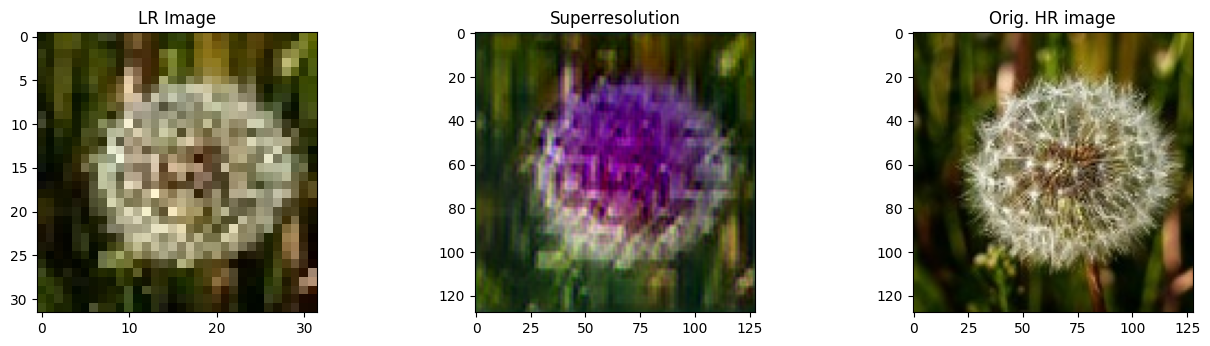

In [18]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/gdrive/MyDrive/Deep_learning/gen_e.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

gen_image = generator.predict(src_image)



plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

1/1 [==============================] - 0s 28ms/step


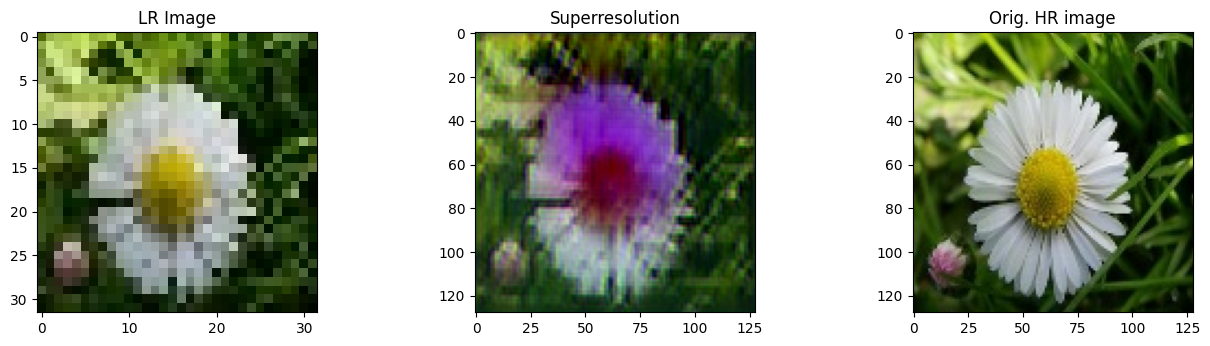

In [20]:
sreeni_lr = cv2.imread("/content/gdrive/MyDrive/Deep_learning/fl_dt/lr_images_1/daisy_1_-105f336ae8dfbb4f.jpg")
sreeni_hr = cv2.imread("/content/gdrive/MyDrive/Deep_learning/fl_dt/hr_images_1/daisy_1_-105f336ae8dfbb4f.jpg")


sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()